# Mutational antigenic profiling of the hemagglutinin of WSN influenza virus by Doud, Hensley, and Bloom (2017)

## Overview
[Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271) performed mutational antigenic profiling of the hemagglutinin (HA) from A/WSN/1933 (H1N1) influenza virus using several strain-specific monoclonal antibodies.
They analyzed the data to determine the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) on each mutation from each antibody.

In that original paper, the data was analyzed using the older [dms_tools](https://jbloomlab.github.io/dms_tools/) software package.
Here we re-analyze the data using the newer [dms_tools2](https://jbloomlab.github.io/dms_tools2/) software.
Because of the use of the newer software, the results will not be numerically identical to those in the original analysis by [Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271), although they will be very close.

## Experimental summary
The goal of the experiment was to completely map the amino-acid mutations that enabled HA to escape from four different monoclonal antibodies plus a control condition:

  * H17-L19 (tested at 3 concentrations). These concentrations are *c1* = 0.5 $\mu$g/ml, *c2* = 1.0 $\mu$g/ml, and *c3* = 10.0 $\mu$g/ml 
    
  * H17-L10
    
  * H17-L7
    
  * H18-S415
  
  * mock (no antibody)
  
  * error control: sequencing of wildtype virus to estimate error rates. 
    
To do this, [Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271) used three independent mutant-virus libraries carrying nearly all codon mutations of HA compatible with viral replication. 
The libraries were selected in the presence and absence of the monoclonal antibodies.
They were then deep sequenced using [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to obtain high accuracy.
This notebook analyzes the data to determine the "differential selection" from each antibody on each mutation in HA.

## Import modules and define general variables
Import Python modules, print version of [dms_tools2](https://github.com/jbloomlab/dms_tools2), define some general variables used throughout the notebook.

Some key variables defined below impact how the entire notebook runs:

* `ncpus` is the number of CPUs to use. It should not exceed the number that you specify if you are submitting your job via a queue-ing system such as `slurm` / `sbatch`.

* `use_existing` specifies whether we use existing results if they exist, or generate everything new. Note that [dms_tools2](https://jbloomlab.github.io/dms_tools2/) programs just check for existing output but do not do true dependency tracking -- so if you have changed the inputs, then change this option from `yes` to `no` to re-run everything fresh.

In [1]:
import os
import pandas
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
from dms_tools2.ipython_utils import showPDF

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

/Users/jbloom/Library/Python/3.5/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using dms_tools2 version 2.0a0


## Define the samples
We first define basic information about the samples needed for processing the barcoded-subamplicon deep sequencing data.
Specifically, we create a [pandas](http://pandas.pydata.org/) DataFrame that gives the:
1. The name of each sample.
2. The SRA ([Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra)) accession for the deep sequencing data for that sample.

The naming scheme is `<antibody>-<library>-c<concentration>`.
So for instance, `H17L19-1r1-c1` is mutant-virus library 1 technical replicate 1 selected with antibody H17L19 at the first antibody concentration.
Technical replicates were only performed for library 1 using antibody H17L19 and the mock selection, so for all other libraries / antibodies, the names are just of the form `H17L19-2-c1`.
Different concentrations were only used for antibody H17L19, so for all other antibodies the names are just of the form `H17L10-1`.

In [2]:
samples = pandas.DataFrame.from_records(
        [('H17L10-1', 'SRR4841597'), 
         ('H17L10-2', 'SRR4841598'), 
         ('H17L10-3', 'SRR4841599'), 
         ('H17L19-1r1-c1', 'SRR4841569'), 
         ('H17L19-1r1-c2', 'SRR4841570'), 
         ('H17L19-1r1-c3', 'SRR4841567'), 
         ('H17L19-1r2-c1', 'SRR4841568'), 
         ('H17L19-1r2-c2', 'SRR4841573'), 
         ('H17L19-1r2-c3', 'SRR4841574'), 
         ('H17L19-2-c1', 'SRR4841571'), 
         ('H17L19-2-c2', 'SRR4841572'), 
         ('H17L19-2-c3', 'SRR4841575'), 
         ('H17L19-3-c1', 'SRR4841576'), 
         ('H17L19-3-c2', 'SRR4841595'), 
         ('H17L19-3-c3', 'SRR4841596'), 
         ('H17L7-1', 'SRR4841600'), 
         ('H17L7-2', 'SRR4841601'), 
         ('H17L7-3', 'SRR4841602'), 
         ('H18S415-1', 'SRR4841603'), 
         ('H18S415-2', 'SRR4841604'), 
         ('H18S415-3', 'SRR4841579'), 
         ('mock-1r1', 'SRR4841578'), 
         ('mock-1r2', 'SRR4841581'), 
         ('mock-2', 'SRR4841580'), 
         ('mock-3', 'SRR4841582'),
         ('err-ctrl', 'SRR3113659')],       
        columns=['name', 'SRA accession']
        )

## Download the FASTQ files from the SRA
Before doing any analysis, we need to obtain the FASTQ files with the deep sequencing data.
[Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) uploaded these FASTQ files to the [Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra), so we simply download those files.

We download the FASTQ files using the [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program from the [SRA Toolkit](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc).
If you do not already have this toolkit installed, you will need to install it by [following these instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std).
For the downloads to work, you need a relatively recent version of [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump), so if this cell fails check your version of that program.

The code cell below does the following:
1. Creates a directory for storing the FASTQ files.
2. Downloads each sample using [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump). To understand the commands, [look here](https://edwards.sdsu.edu/research/fastq-dump/) since the [NCBI's instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) are sparse.
2. Renames each set of FASTQ files to have nice names like `mutDNA-1_R1.fastq.gz` / `mutDNA-1_R2.fastq.gz`.

Note that files are only downloaded if they do not already exist.
Note also that the downloads can take a while to complete.

In [3]:
print("Downloading FASTQ files from the SRA using:")
!fastq-dump --version

# directory for FASTQ files
fastqdir = './FASTQ_files/' 
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)

# define the R1 FASTQ file name (file will be in fastqdir)
samples['R1'] = samples['name'] + '_R1.fastq.gz'

# download any FASTQ files that are not already present
for (i, row) in samples.iterrows():
    # r1filedownload / r2filedownload are initial file names given by fastq-dump 
    r1filedownload = os.path.join(fastqdir, '{0}_pass_1.fastq.gz'.format(row['SRA accession']))
    r2filedownload = r1filedownload.replace('_1.fastq.gz', '_2.fastq.gz')
    r1file = os.path.join(fastqdir, row['R1'])
    r2file = r1file.replace('_R1', '_R2')
    if os.path.isfile(r1file) and os.path.isfile(r2file):
        print("FASTQ files for {0} already exist".format(row['name']))
    else:
        print("Downloading FASTQ files for {0}...".format(row['name']))
        !fastq-dump --outdir {fastqdir} --gzip --readids --skip-technical \
                --dumpbase --clip --split-files --read-filter pass {row['SRA accession']}
        os.rename(r1filedownload, r1file)
        os.rename(r2filedownload, r2file)


fastq-dump : 2.8.2

FASTQ files for H17L10-1 already exist
FASTQ files for H17L10-2 already exist
FASTQ files for H17L10-3 already exist
FASTQ files for H17L19-1r1-c1 already exist
FASTQ files for H17L19-1r1-c2 already exist
FASTQ files for H17L19-1r1-c3 already exist
FASTQ files for H17L19-1r2-c1 already exist
FASTQ files for H17L19-1r2-c2 already exist
FASTQ files for H17L19-1r2-c3 already exist
FASTQ files for H17L19-2-c1 already exist
FASTQ files for H17L19-2-c2 already exist
FASTQ files for H17L19-2-c3 already exist
FASTQ files for H17L19-3-c1 already exist
FASTQ files for H17L19-3-c2 already exist
FASTQ files for H17L19-3-c3 already exist
FASTQ files for H17L7-1 already exist
FASTQ files for H17L7-2 already exist
FASTQ files for H17L7-3 already exist
FASTQ files for H18S415-1 already exist
FASTQ files for H18S415-2 already exist
FASTQ files for H18S415-3 already exist
FASTQ files for mock-1r1 already exist
FASTQ files for mock-1r2 already exist
FASTQ files for mock-2 already exi

## Align the deep sequencing data and count mutations
[Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) used [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to obtain high accuracy during the Illumina deep sequencing.

We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and `--alignspecs` that tell us where the subamplicons should align.
The batch file that we specify is printed by the cell below.
The alignments are made to the wildtype WSN HA coding sequence, which is available at [./data/WSN-HA.fasta](./data/WSN-HA.fasta).
The alignment specs are specified based on the exact primers used for the [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) by [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155). 
The alignment specs need to be exactly correct for the subamplicons to align.

We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 
Such trimming can be crucial for getting good results, since the read quality often drops off at the end of reads.
In the example below, we have trimmed all subamplicons equally, but in some cases you might want to trim each one differently by specifying a list of values for each subamplicon.

In [4]:
# file containing wildtype WSN HA sequence
refseq = './data/WSN-HA.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples.to_html(index=False)))
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,SRA accession,R1
H17L10-1,SRR4841597,H17L10-1_R1.fastq.gz
H17L10-2,SRR4841598,H17L10-2_R1.fastq.gz
H17L10-3,SRR4841599,H17L10-3_R1.fastq.gz
H17L19-1r1-c1,SRR4841569,H17L19-1r1-c1_R1.fastq.gz
H17L19-1r1-c2,SRR4841570,H17L19-1r1-c2_R1.fastq.gz
H17L19-1r1-c3,SRR4841567,H17L19-1r1-c3_R1.fastq.gz
H17L19-1r2-c1,SRR4841568,H17L19-1r2-c1_R1.fastq.gz
H17L19-1r2-c2,SRR4841573,H17L19-1r2-c2_R1.fastq.gz
H17L19-1r2-c3,SRR4841574,H17L19-1r2-c3_R1.fastq.gz
H17L19-2-c1,SRR4841571,H17L19-2-c1_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp).
All of these files are found in the directory specified by `--outdir`, and with the prefix specified by `summaryprefix`.
So we define them using this plot prefix plus the suffix for each plot.

In [5]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads.
This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. 
None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA using `fastq-dump`.

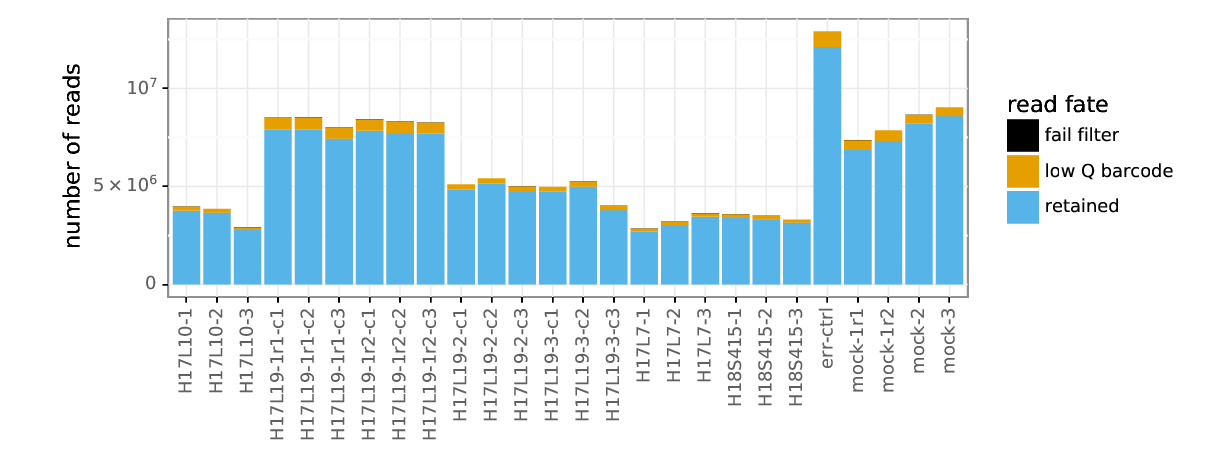

In [6]:
showPDF(countsplotprefix + '_readstats.pdf')

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample.
Barcodes need to be observed multiple times to be useful for [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) error correction.

For many samples (such as *mock-2* or *H17-L19-1r1-c3*), most barcodes are observed multiple times except for a small peak at one that likely is due in substantial part of one-off barcodes generated by sequencing errors. Such samples are clearly sequenced to (more-than) adequate depth. But for other samples (such as *mock-1r1*) it's clear from the distribution that many barcodes were observed only once (or possibly not at all), and so more seuqencing depth might give greater coverage of called mutations. 

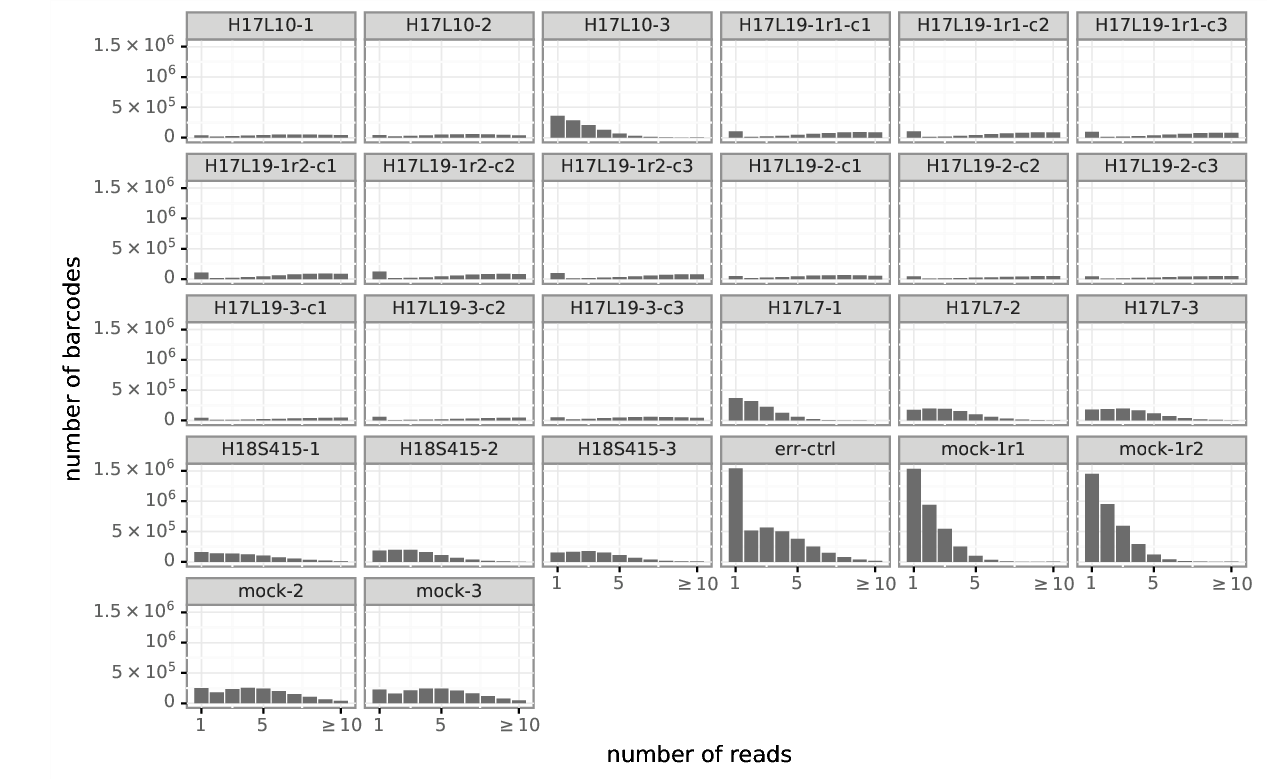

In [7]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes.
Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the HA gene properly. 

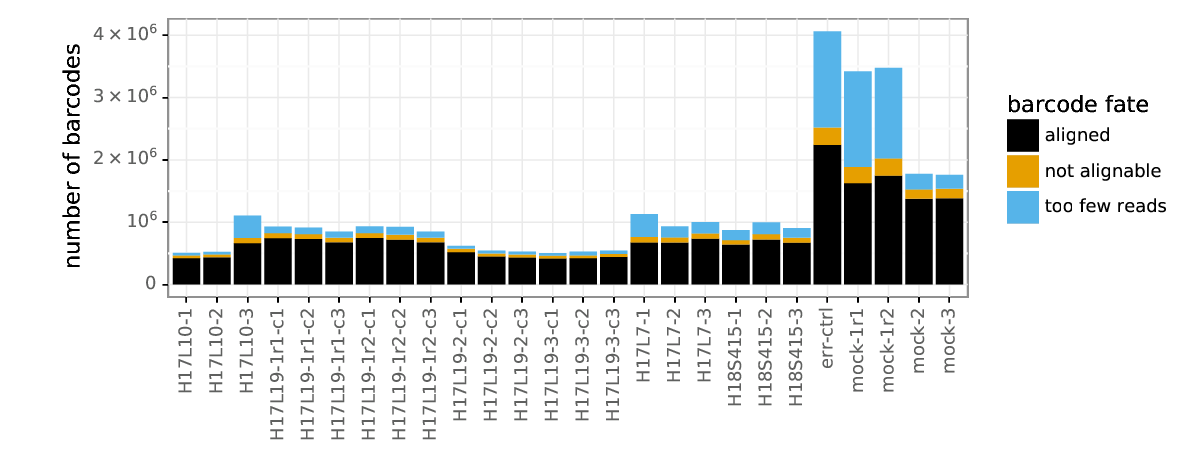

In [8]:
showPDF(countsplotprefix + '_bcstats.pdf')

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene.
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly. 
Note that some samples (in particular the *mock* samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the *mock* samples.

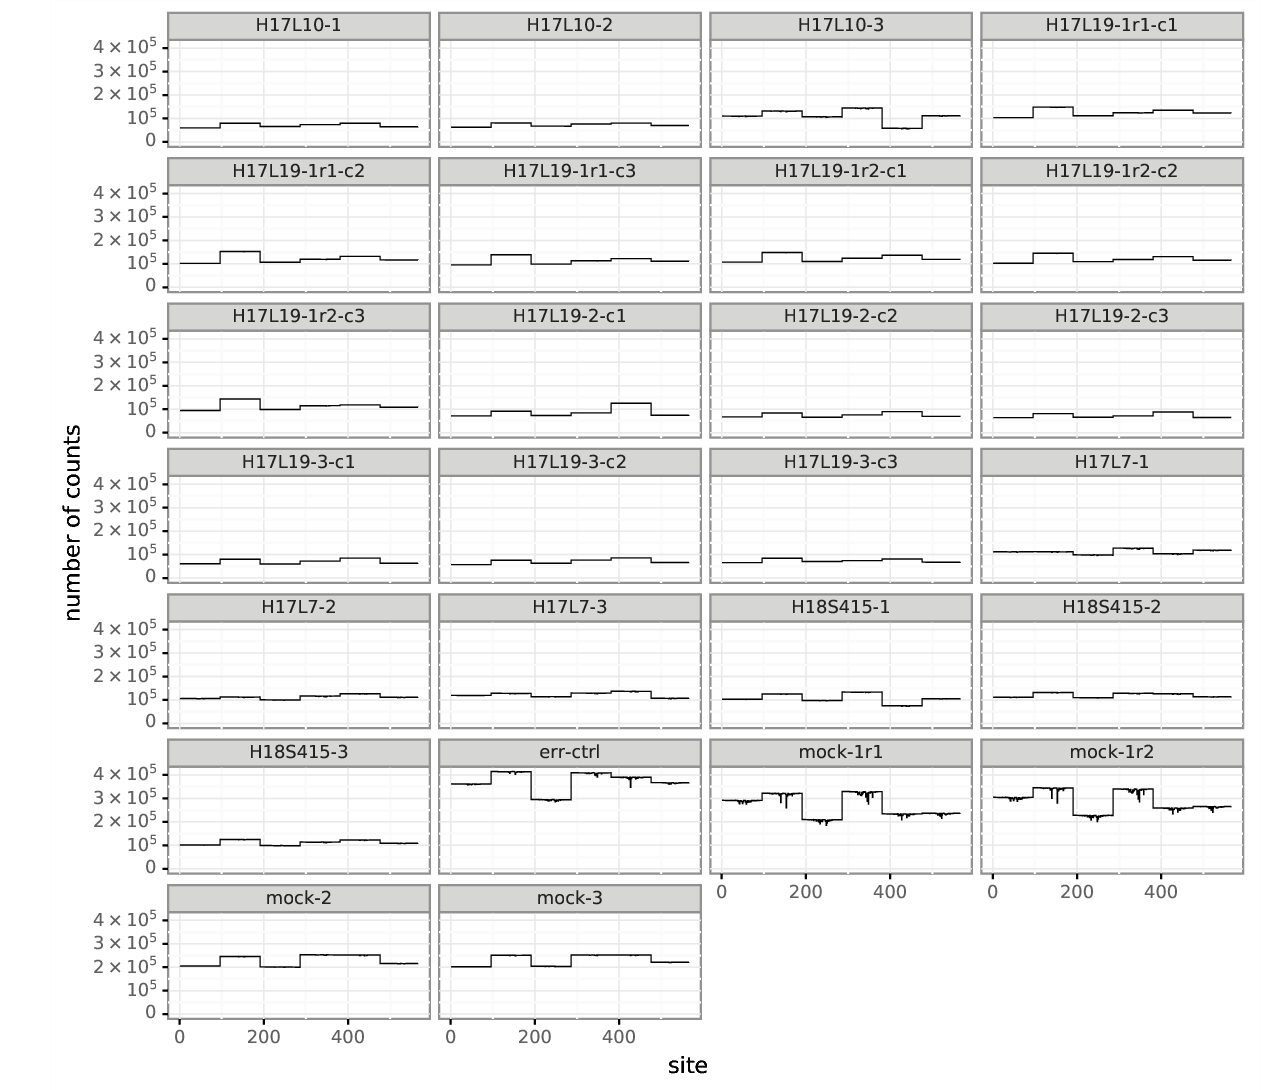

In [9]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site.
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates for the same antibody, and so presumably represent the sites where antibody-escape mutations are selected.
For *H17L19*, you can see that the height of the peaks go up at higher antibody concentration (going from *c1* to *c3*).
There are no such peaks for the *mock* sample since there is no antibody selection to favor specific mutations.

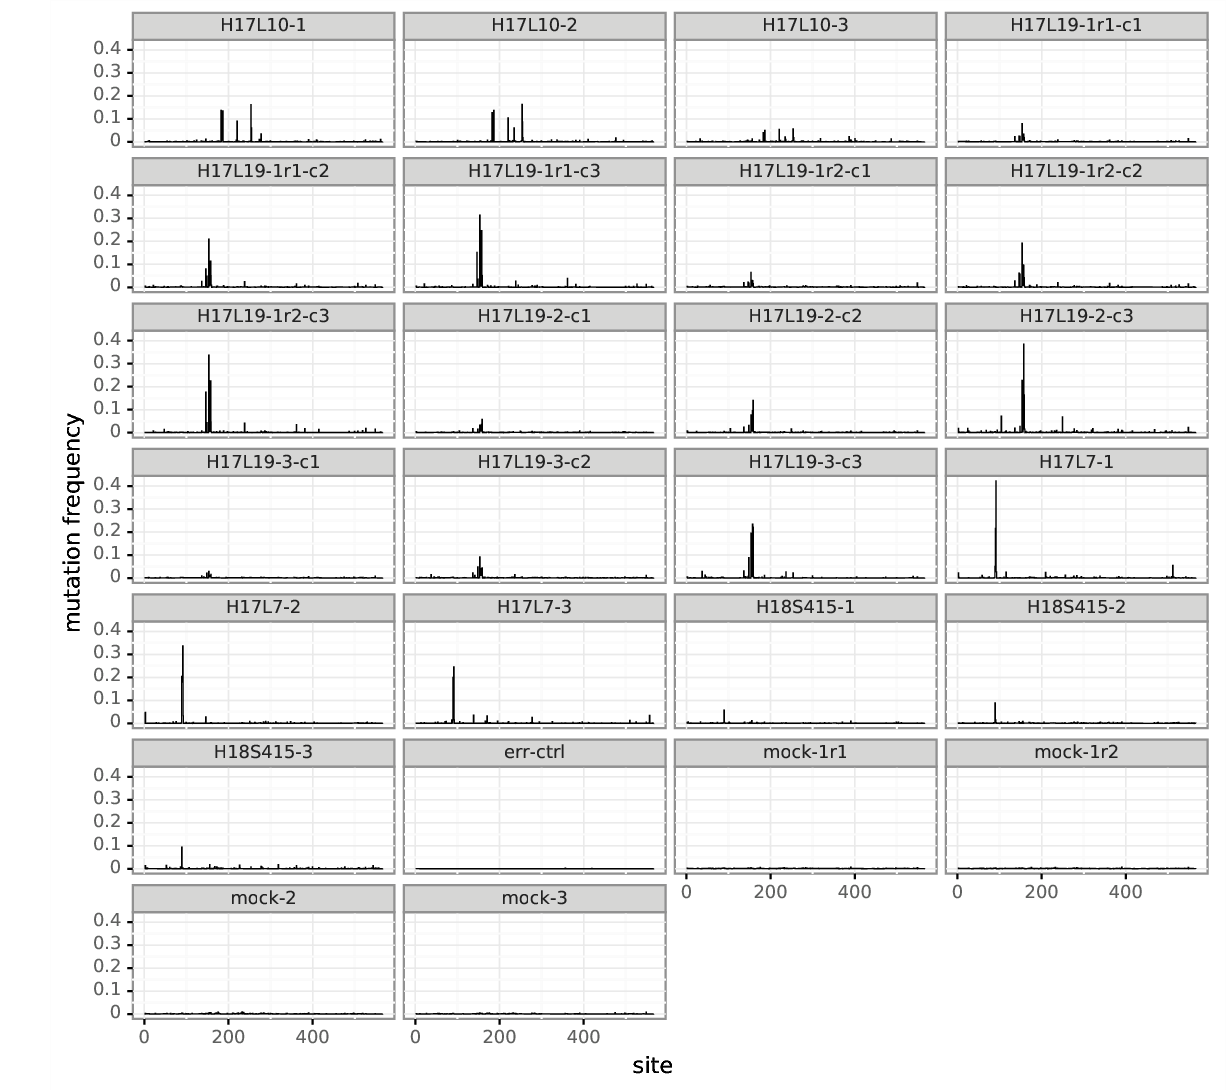

In [10]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene.
For some of the strongly antibody selected samples, we see an overall increase in the per-codon mutation frequency due to very strong selection for variants with escape mutations.

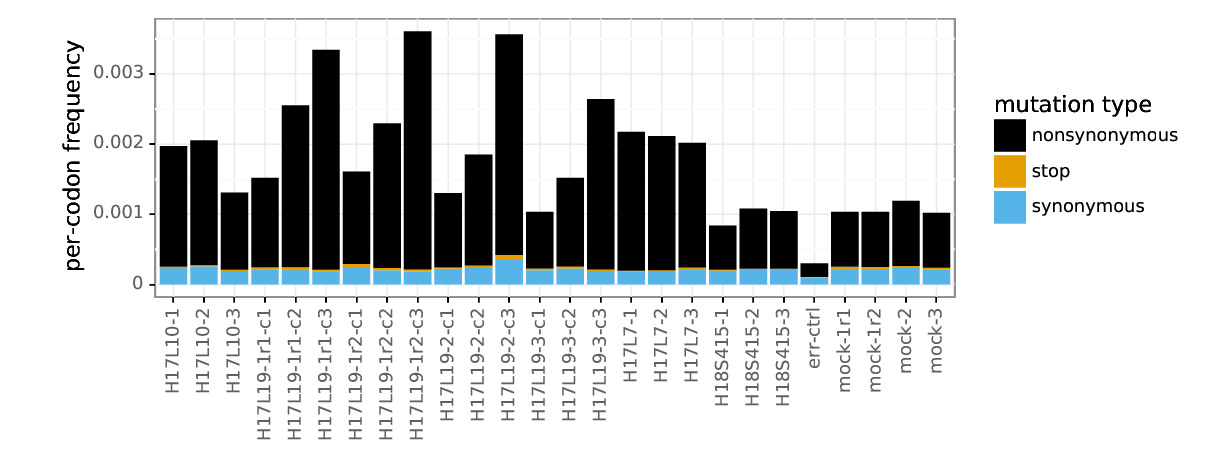

In [11]:
showPDF(countsplotprefix + '_codonmuttypes.pdf')

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., `ATG` to `AAG` changes 1 nucleotide, `ATG` to `AAC` changes 2 nucleotides, and `ATG` to `CAC` changes 3 nucleotides).

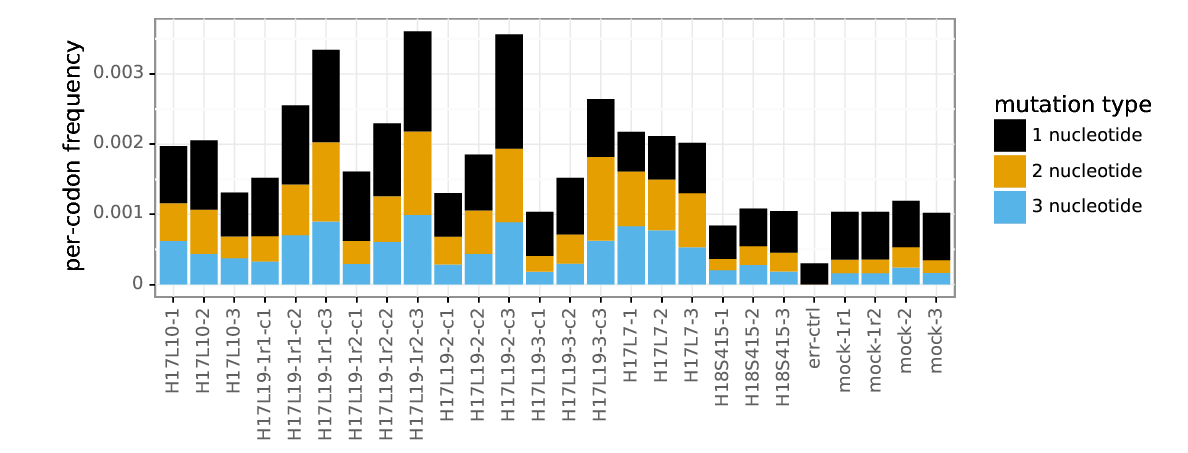

In [12]:
showPDF(countsplotprefix + '_codonntchanges.pdf')

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with **one** nucleotide change.
This plot is mostly useful to check if there is a large bias in which mutations appear. 
In particular, if you are getting [oxidative damage (which causes `G` to `T` mutations)](https://dx.doi.org/10.1038/349431a0) during the library preparation process, you will see a large excess of `C` to `A` or `G` to `T` mutations (or both).
For instance, in the case of influenza, when we get bad oxidative damage, then we see an excess of `C` to `A` mutations in the final cDNA since the damage is occurring to a ssRNA genome.
If you are sequencing something without polarity, you might see both types of mutations.

There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (`G` <-> `A` and `C` <-> `T`) are a bit more common than most of the other types of mutations (all of which are transversions).
This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/).

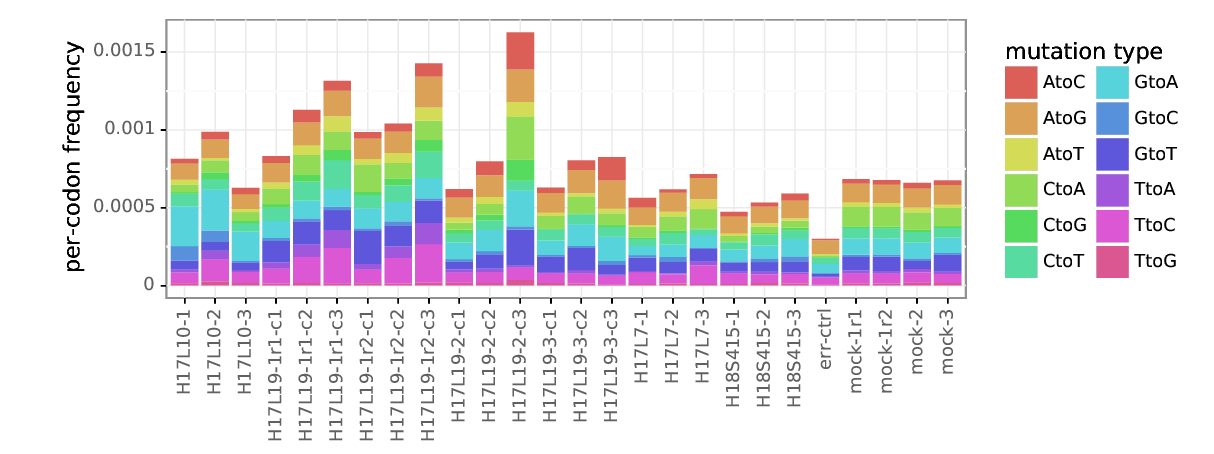

In [13]:
showPDF(countsplotprefix + '_singlentchanges.pdf')

## Analyze differential selection

We first create a batch file to use with [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).
Note that we make the `group` arguments the antibody, the `name` argument the replicate, and assign the `sel`, `mock`, and `err` arguments based on the names used for the batch file when generating the counts files above with [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

By grouping replicates for the same antibody in the batch file, we tell [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) to analyze these together and take their mean and median. 

For the concentrations of H17L19, we convert from $\mu$g/ml to nM assuming an [IgG molecular weight of 150 kDa](https://www.ncbi.nlm.nih.gov/books/NBK27144/), and using [this calculator](http://molbiol.edu.ru/eng/scripts/01_04.html).
The reason that we indicate the concentration in nM rather than $\mu$g/ml is something that it doesn't require us to use special characters (such as `/`) that are not allowed in the `group` argument. 

In [14]:
# put diffsel values here
diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)
    
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')

diffselbatch = pandas.DataFrame.from_records([
         # H17L19 at 0.5 ug/ml, or 3.3 nM
         ('H17L19-3-nM', 'replicate-1a', 'H17L19-1r1-c1', 'mock-1r1'), 
         ('H17L19-3-nM', 'replicate-1b', 'H17L19-1r2-c1', 'mock-1r2'),
         ('H17L19-3-nM', 'replicate-2', 'H17L19-2-c1', 'mock-2'),
         ('H17L19-3-nM', 'replicate-3', 'H17L19-3-c1', 'mock-3'),
         # H17L19 and 1 ug/ml, or 6.7 nM
         ('H17L19-7-nM', 'replicate-1a', 'H17L19-1r1-c2', 'mock-1r1'),
         ('H17L19-7-nM', 'replicate-1b', 'H17L19-1r2-c2', 'mock-1r2'),
         ('H17L19-7-nM', 'replicate-2', 'H17L19-2-c2', 'mock-2'),
         ('H17L19-7-nM', 'replicate-3', 'H17L19-3-c2', 'mock-3'),
         # H179L19 at 10 ug/ml, or 67 nM
         ('H17L19-67-nM', 'replicate-1a', 'H17L19-1r1-c3', 'mock-1r1'),  
         ('H17L19-67-nM', 'replicate-1b', 'H17L19-1r2-c3', 'mock-1r2'),        
         ('H17L19-67-nM', 'replicate-2', 'H17L19-2-c3', 'mock-2'), 
         ('H17L19-67-nM', 'replicate-3', 'H17L19-3-c3', 'mock-3'),  
         # H17L10 at 3 ug/ml
         ('H17L10', 'replicate-1', 'H17L10-1', 'mock-1r1'), 
         ('H17L10', 'replicate-2', 'H17L10-2', 'mock-2'), 
         ('H17L10', 'replicate-3', 'H17L10-3', 'mock-3'), 
         # H17L7 at 15 ug/ml
         ('H17L7', 'replicate-1', 'H17L7-1', 'mock-1r1'), 
         ('H17L7', 'replicate-2', 'H17L7-2', 'mock-2'), 
         ('H17L7', 'replicate-3', 'H17L7-3', 'mock-3'), 
         # H18S415 at 3 ug/ml
         ('H18S415', 'replicate-1', 'H18S415-1', 'mock-1r1'), 
         ('H18S415', 'replicate-2', 'H18S415-2', 'mock-2'), 
         ('H18S415', 'replicate-3', 'H18S415-3', 'mock-3'), 
        ],       
        columns=['group', 'name', 'sel', 'mock']
        )
diffselbatch['err'] = 'err-ctrl' # all samples have the same error control

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,sel,mock,err
H17L19-3-nM,replicate-1a,H17L19-1r1-c1,mock-1r1,err-ctrl
H17L19-3-nM,replicate-1b,H17L19-1r2-c1,mock-1r2,err-ctrl
H17L19-3-nM,replicate-2,H17L19-2-c1,mock-2,err-ctrl
H17L19-3-nM,replicate-3,H17L19-3-c1,mock-3,err-ctrl
H17L19-7-nM,replicate-1a,H17L19-1r1-c2,mock-1r1,err-ctrl
H17L19-7-nM,replicate-1b,H17L19-1r2-c2,mock-1r2,err-ctrl
H17L19-7-nM,replicate-2,H17L19-2-c2,mock-2,err-ctrl
H17L19-7-nM,replicate-3,H17L19-3-c2,mock-3,err-ctrl
H17L19-67-nM,replicate-1a,H17L19-1r1-c3,mock-1r1,err-ctrl
H17L19-67-nM,replicate-1b,H17L19-1r2-c3,mock-1r2,err-ctrl


Now we simply run [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html), getting the input counts from the directory (`--indir`) that we placed the counts when we ran [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

In [15]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {countsdir} \
        --use_existing {use_existing}

Running this command creates a large number of output files giving the mutation and site [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) values in the formats of the `mutdiffsel.csv` and `sitediffsel.csv` files created by [dms2_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_diffsel.html).

Specifically, there is a file for each individual sample, with a file name that gives the `group` and `name` specified for this sample in `--batchfile`.
For instance, here are the files for the individual samples in `group` *H17-L10*:

In [16]:
!ls {diffseldir}/H17L10*.csv

./results/diffsel/H17L10-replicate-1_mutdiffsel.csv
./results/diffsel/H17L10-replicate-1_sitediffsel.csv
./results/diffsel/H17L10-replicate-2_mutdiffsel.csv
./results/diffsel/H17L10-replicate-2_sitediffsel.csv
./results/diffsel/H17L10-replicate-3_mutdiffsel.csv
./results/diffsel/H17L10-replicate-3_sitediffsel.csv


There are also files giving the mean and median differential selection for **all** samples in each group.
These files are prefixed with the name given by `--summaryprefix` (in this case, `summary`), and also indicate the group.
For instance, here are the files for the `group` *H17-L10*:

In [17]:
!ls {diffseldir}/summary*H17L10*.csv

./results/diffsel/summary_H17L10-meanmutdiffsel.csv
./results/diffsel/summary_H17L10-meansitediffsel.csv
./results/diffsel/summary_H17L10-medianmutdiffsel.csv
./results/diffsel/summary_H17L10-mediansitediffsel.csv
./results/diffsel/summary_H17L10_known_escape.csv


Now we are going to look at the correlation of samples **within** a given group.
We have six groups, so there are six sets of correlations.

Running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) creates correlation plots for the mutation differential selection, positive site differential selection, absolute site differential selection, and maximum mutation differential selection for a site.
These files have names like `summary_H17L10-mutdiffselcorr.pdf`.
Below we show the plots for `mutdiffsel` and `positivesitediffsel` (ones are also made for `absolutesitediffsel` and `maxsitediffsel`, but are not shown below as they are less informative for this experiment).
Note that the plots show the correlations between all pairs, and also on the diagonal show the density of the different selection values for each replicates (most of them are close to zero).


mutdiffsel correlations:


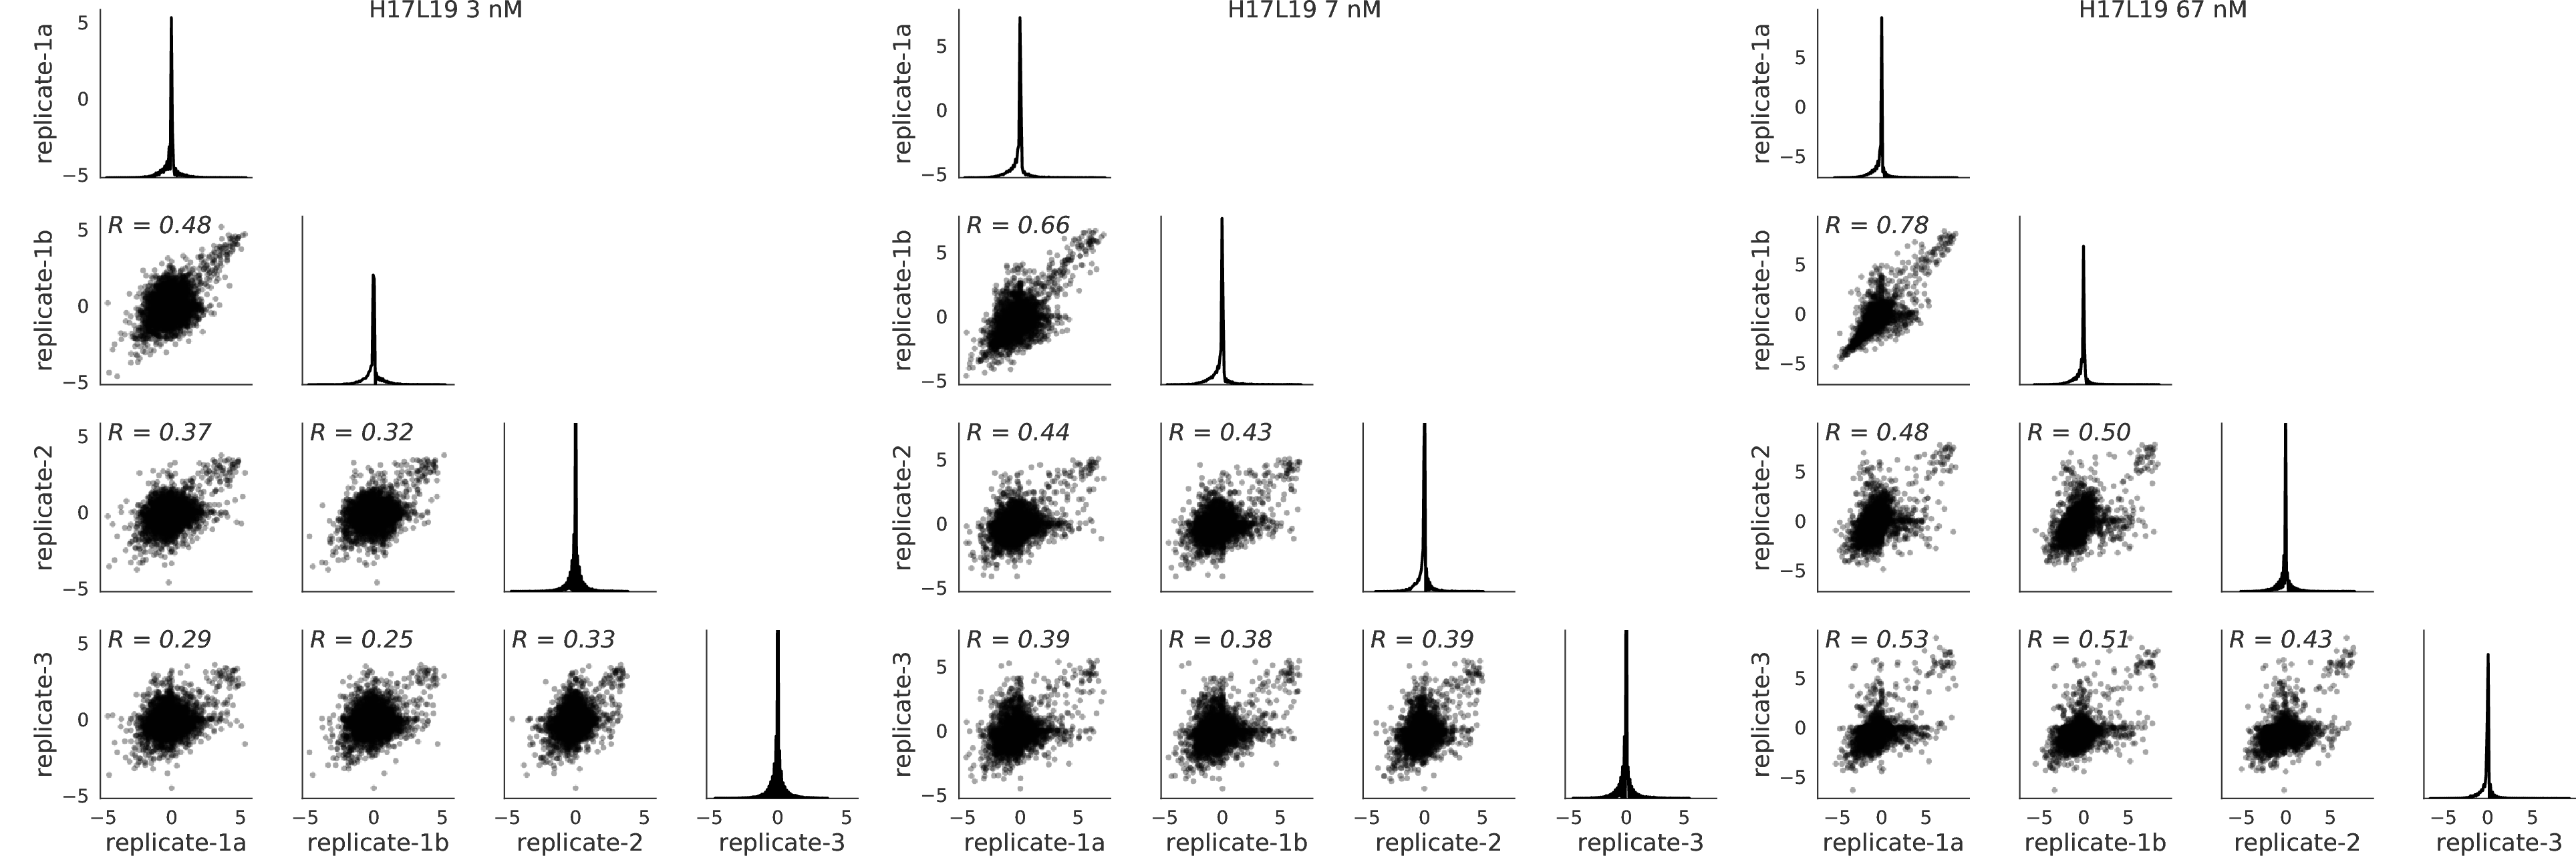

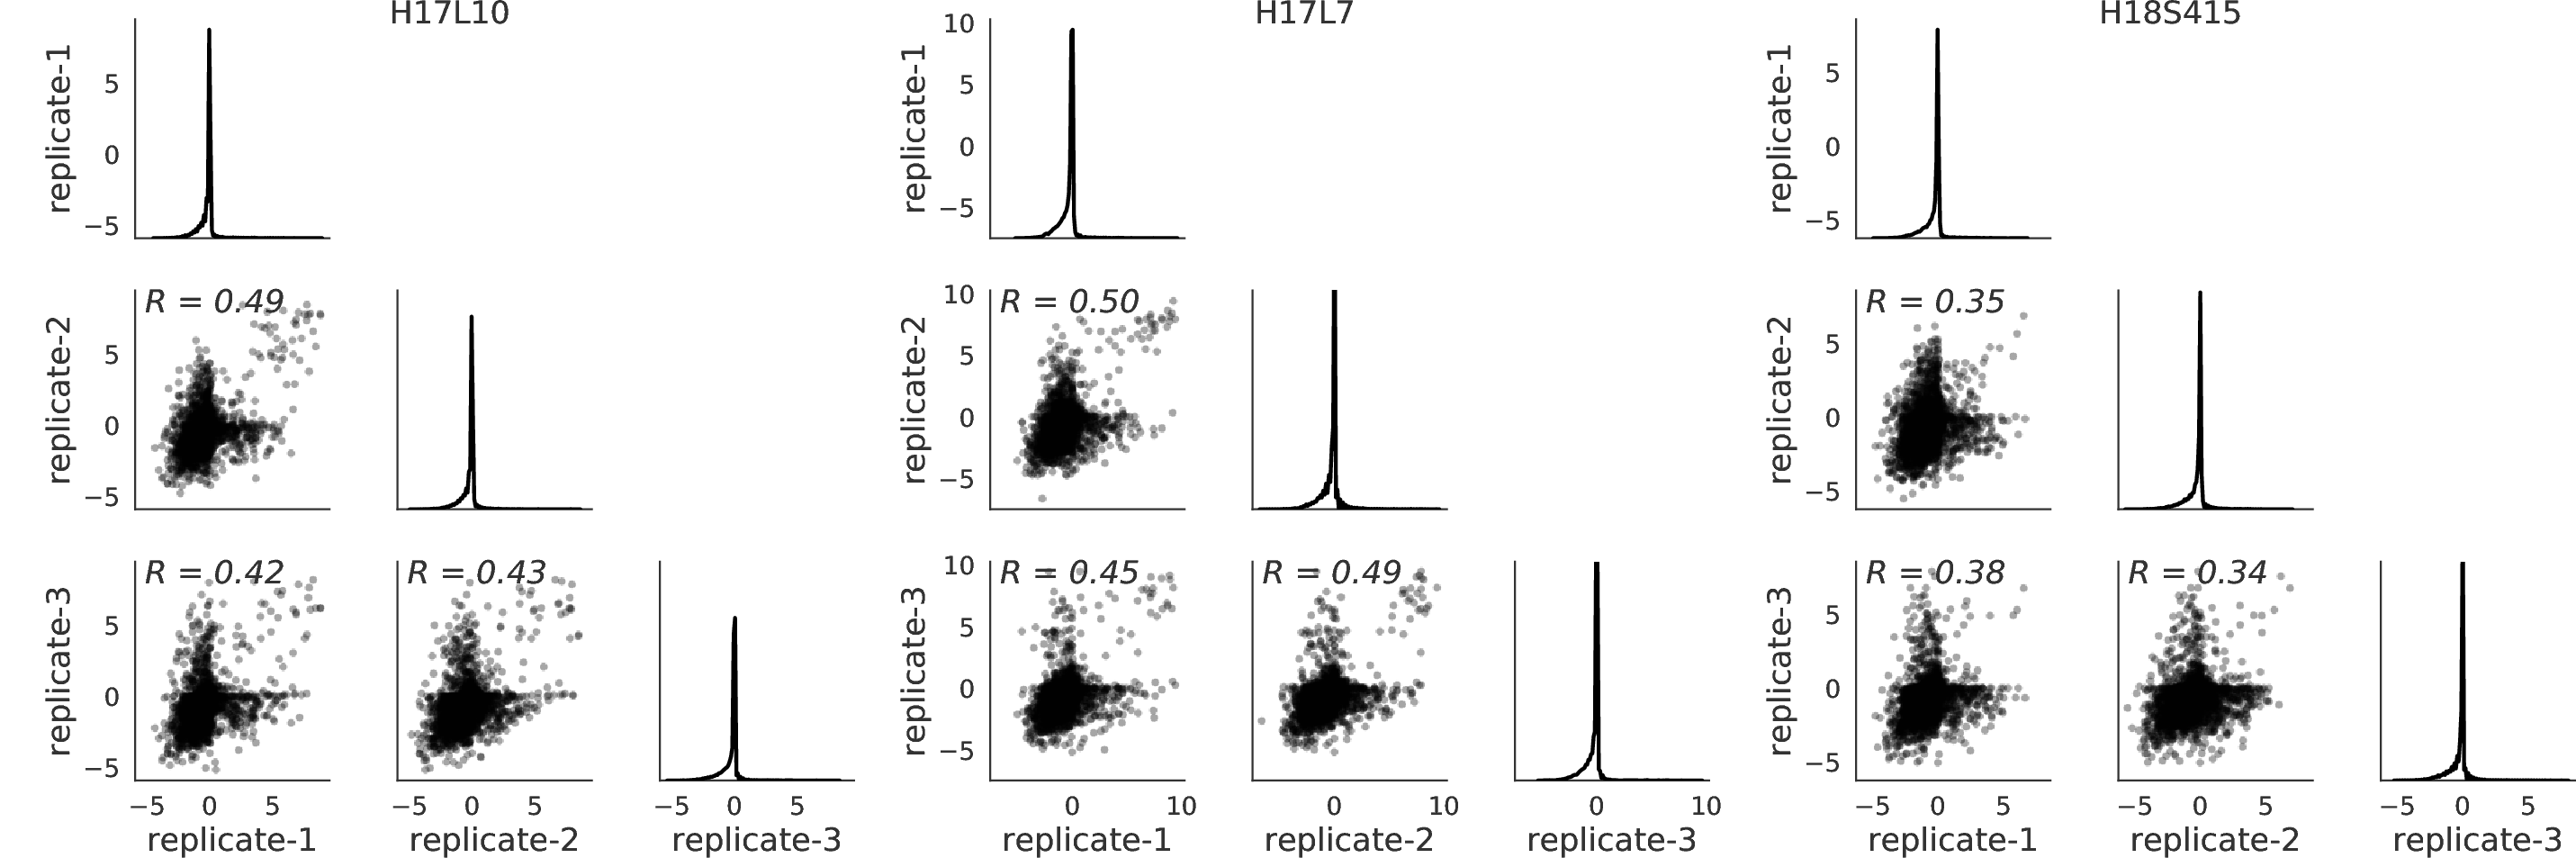


positivesitediffsel correlations:


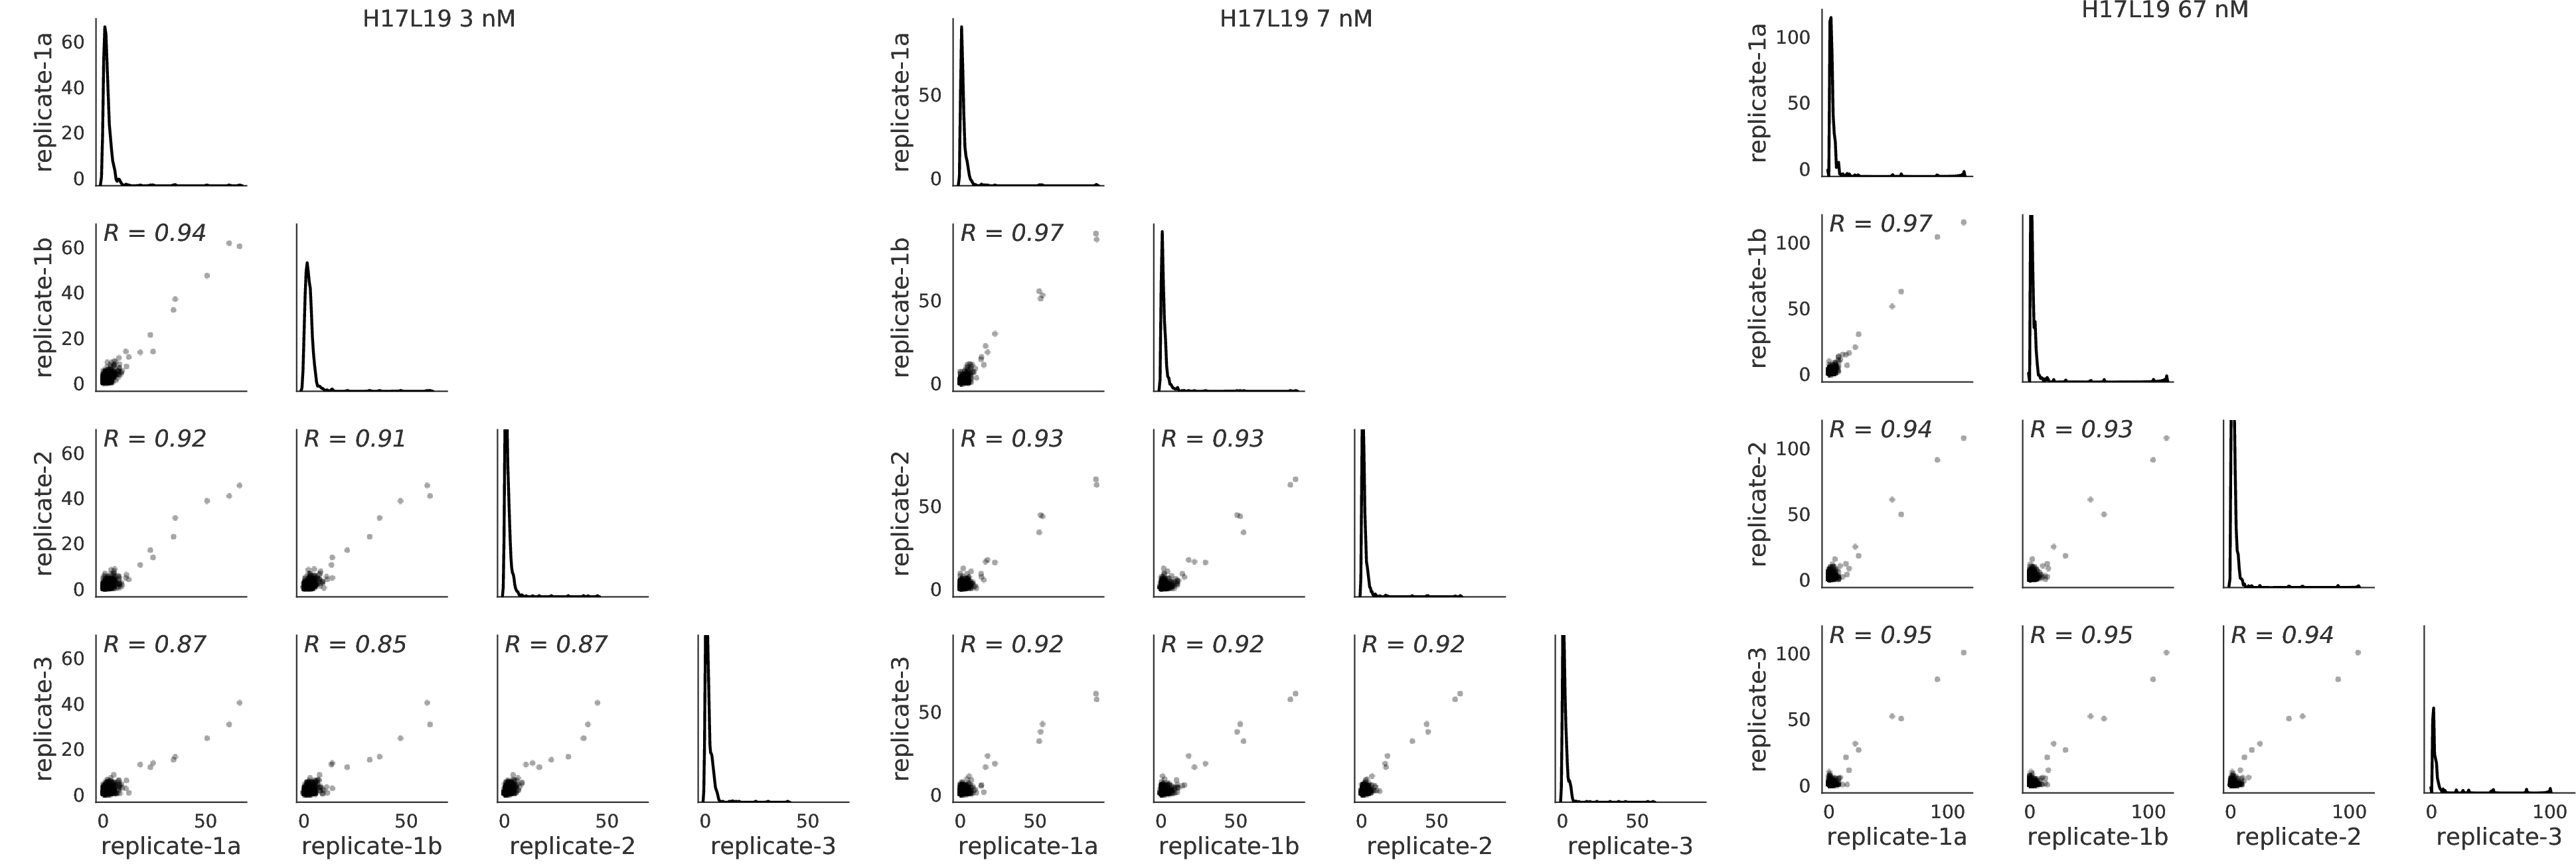

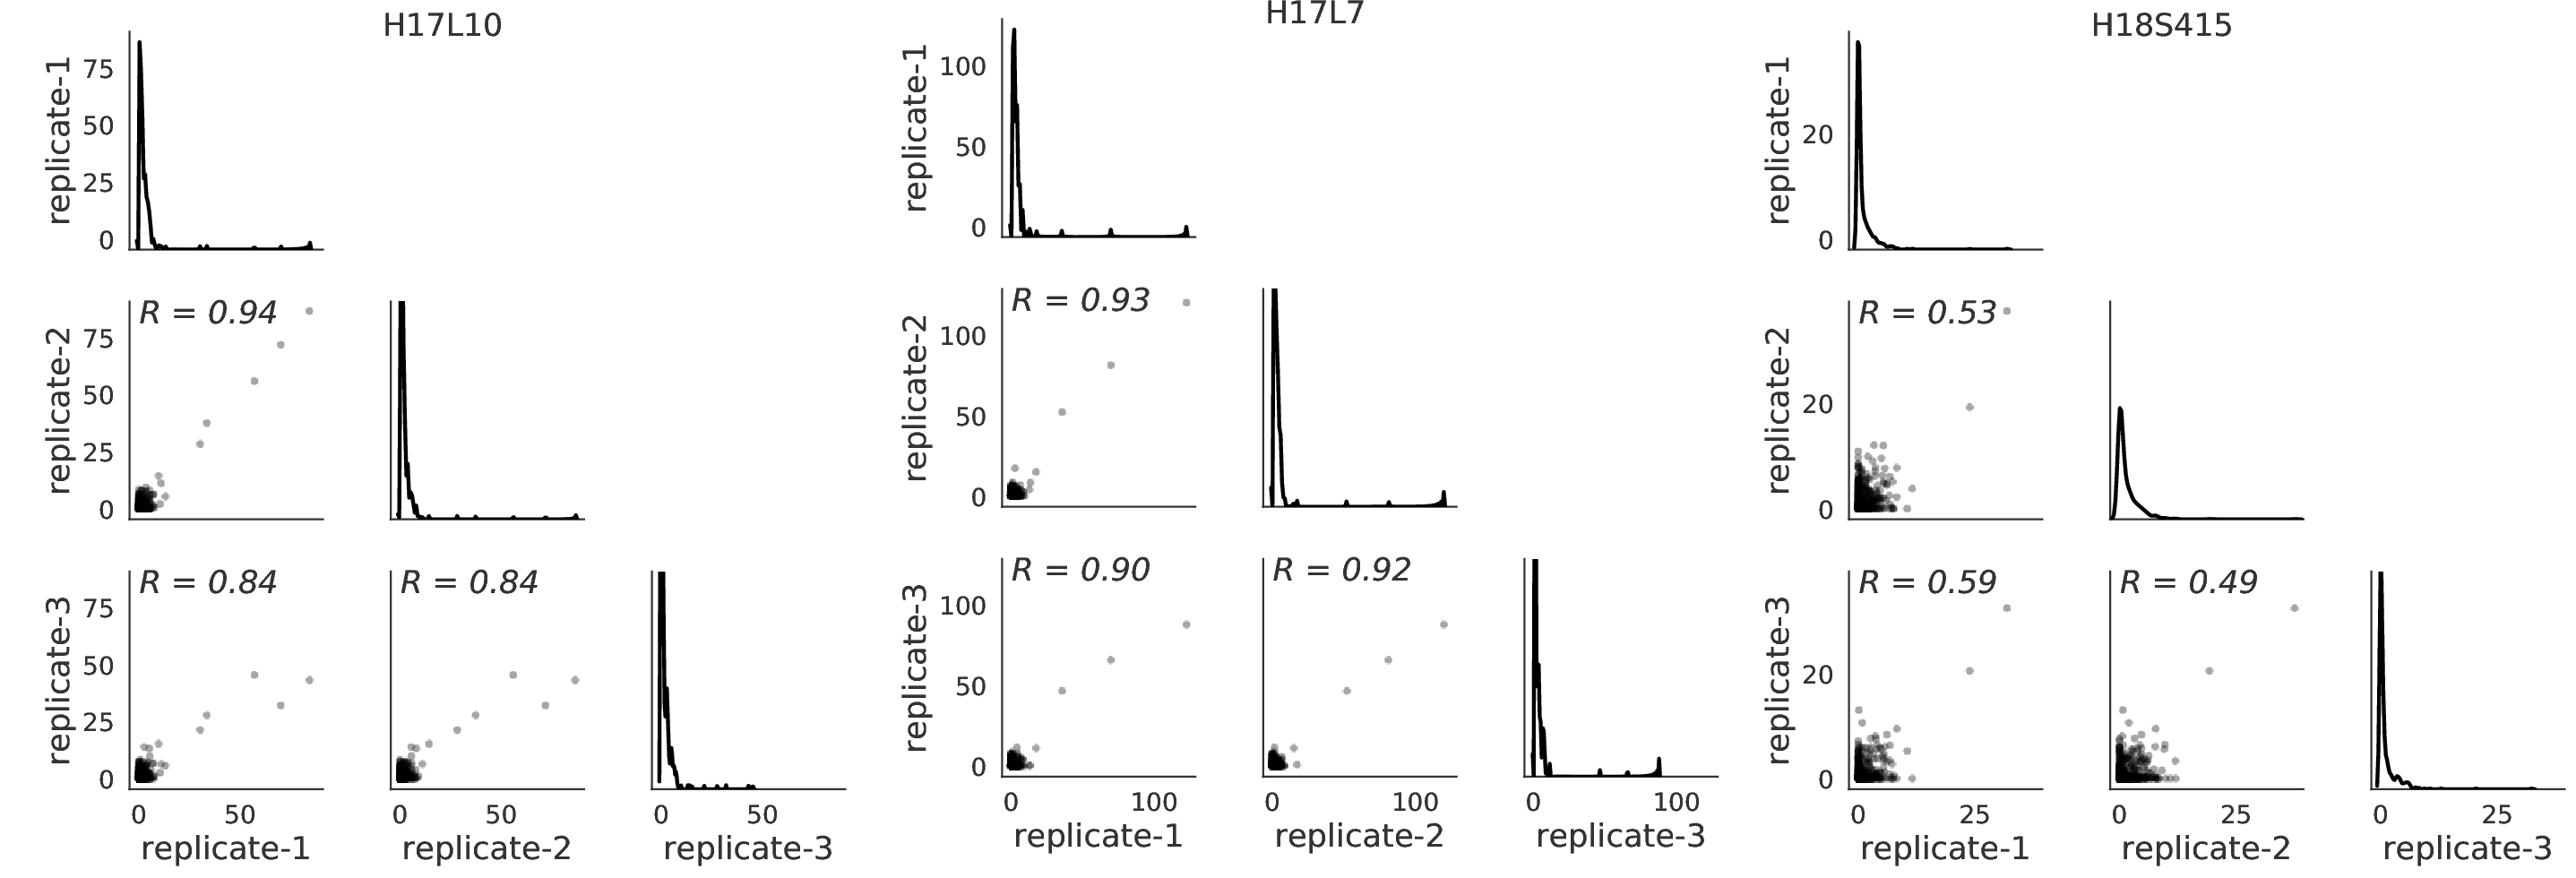

In [18]:
diffselprefix = os.path.join(diffseldir, 'summary_')
groups = diffselbatch['group'].unique()

for seltype in ['mutdiffsel', 'positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = diffselprefix + g + '-' + seltype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots[ : 3]) # show first 3 plots
    showPDF(plots[3 : ], width=800) # show remaining plots

We can also look at the mean correlation for H17L19 at the different concentrations.
[dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) does not make this plot automatically, but we can make it using the `dms_tools2.plot.plotCorrMatrix` function from the [dms_tools2 Python API](https://jbloomlab.github.io/dms_tools2/api.html).
Here we make this plot for the positive site differential selection:

/Users/jbloom/Library/Python/3.5/lib/python/site-packages/matplotlib/tight_layout.py:226: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/Users/jbloom/Library/Python/3.5/lib/python/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


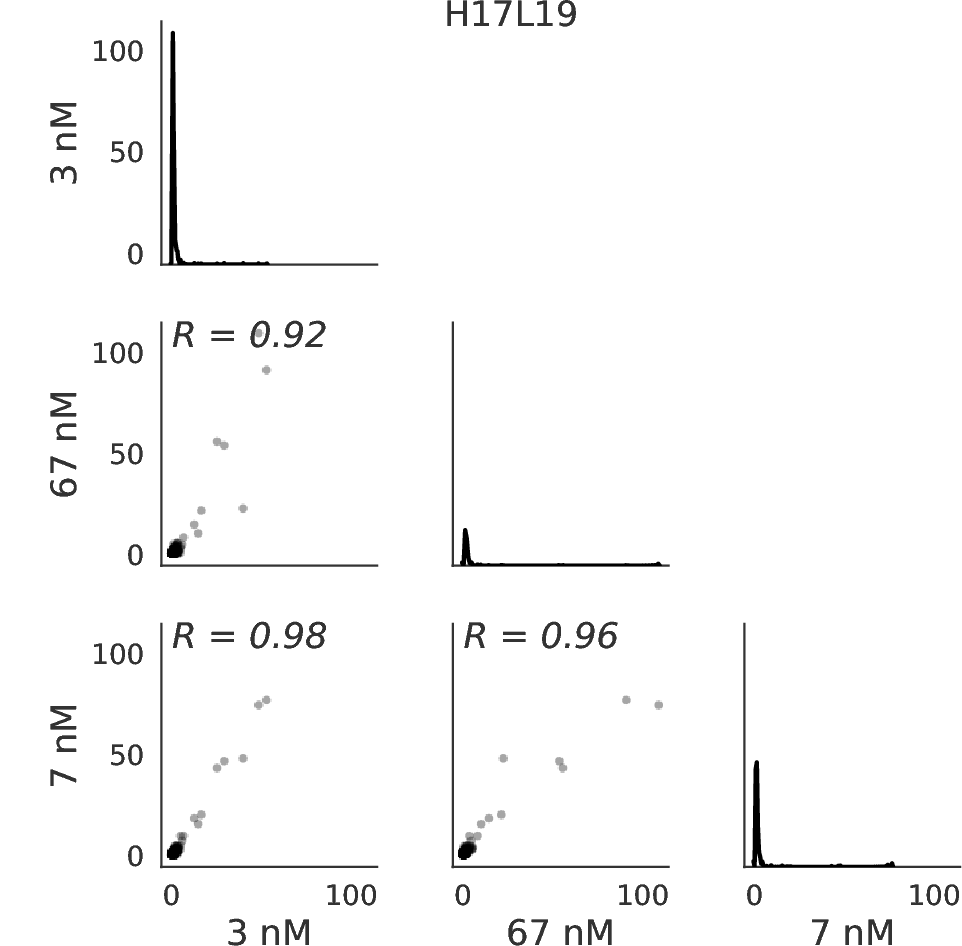

In [19]:
concs = ['3-nM', '7-nM', '67-nM']
plotfile = diffselprefix + 'conc_corr_H17L19.pdf'
dms_tools2.plot.plotCorrMatrix(
        [c.replace('-', ' ') for c in concs],
        [diffselprefix + 'H17L19-{0}-meansitediffsel.csv'.format(c) 
                for c in concs],
        plotfile, 'positive_diffsel', title='H17L19')
showPDF(plotfile, width=300)

Now we look at the differential selection along the primary sequence.
Several plots showing this kind of selection are made by [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).
These plots show either the **mean** or the **median** differential selection among all samples in each group (CSV files have been created containing this differential selection as described above).

These files all have the prefix indicated by `--summaryprefix`, and show the positive differential selection, total site differential selection (both positive and negative), the maximum differential selection, and the minimum and maximum differential selection. 
Here are all the files created by this analysis:

In [20]:
!ls {diffseldir}/*diffsel.pdf

./results/diffsel/summary_meanmaxdiffsel.pdf
./results/diffsel/summary_meanminmaxdiffsel.pdf
./results/diffsel/summary_meanpositivediffsel.pdf
./results/diffsel/summary_meantotaldiffsel.pdf
./results/diffsel/summary_medianmaxdiffsel.pdf
./results/diffsel/summary_medianminmaxdiffsel.pdf
./results/diffsel/summary_medianpositivediffsel.pdf
./results/diffsel/summary_mediantotaldiffsel.pdf


For this particular experiment, the median and mean values look very similar, but for some experiments one might look a lot better than another if there are clear outlier measurements in some samples.
For instance, below are the mean and median side-by-side for the total site differential selection (note how this plot shows both the positive and negative values, with the mean values at left and the median values at right:

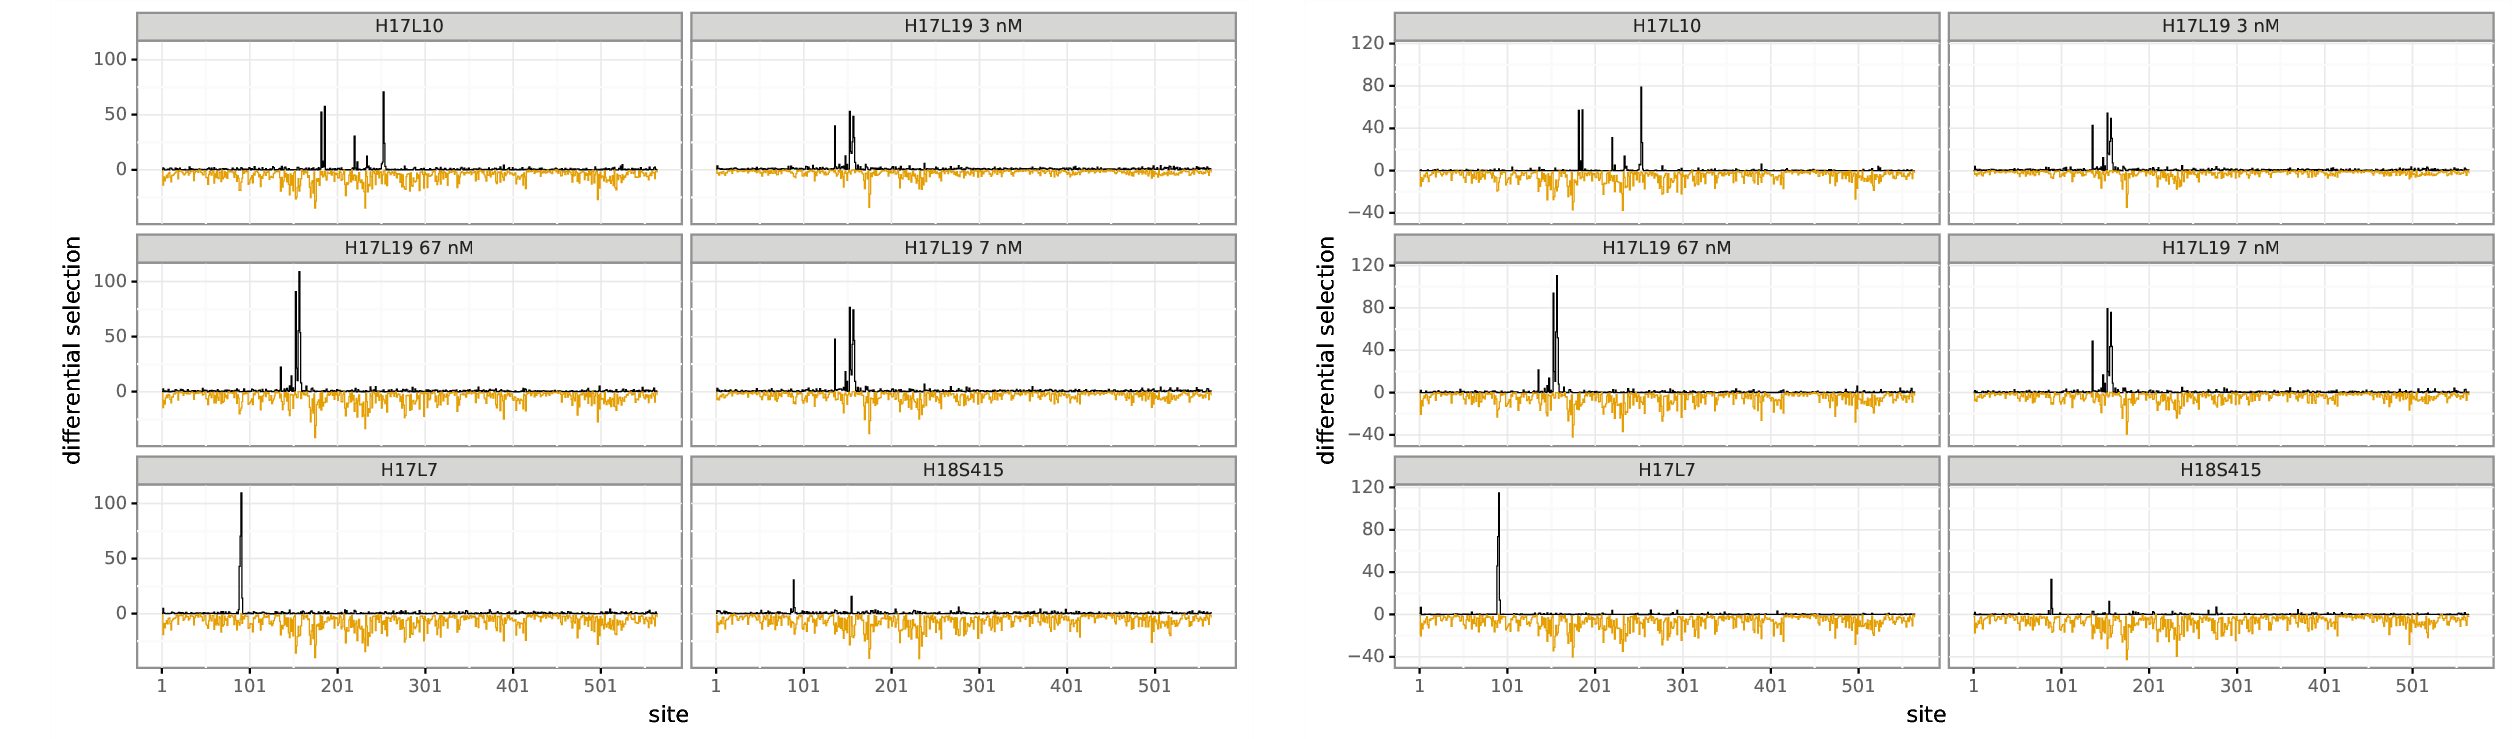

In [21]:
showPDF([diffselprefix + 'meantotaldiffsel.pdf', diffselprefix + 'mediantotaldiffsel.pdf'])

Probably the most informative plot is simply the mean positive site differential selection -- this is what [Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271) show in their paper.
This plot shows the total positive selection for **all** mutations combined at a given site, and is shown below:

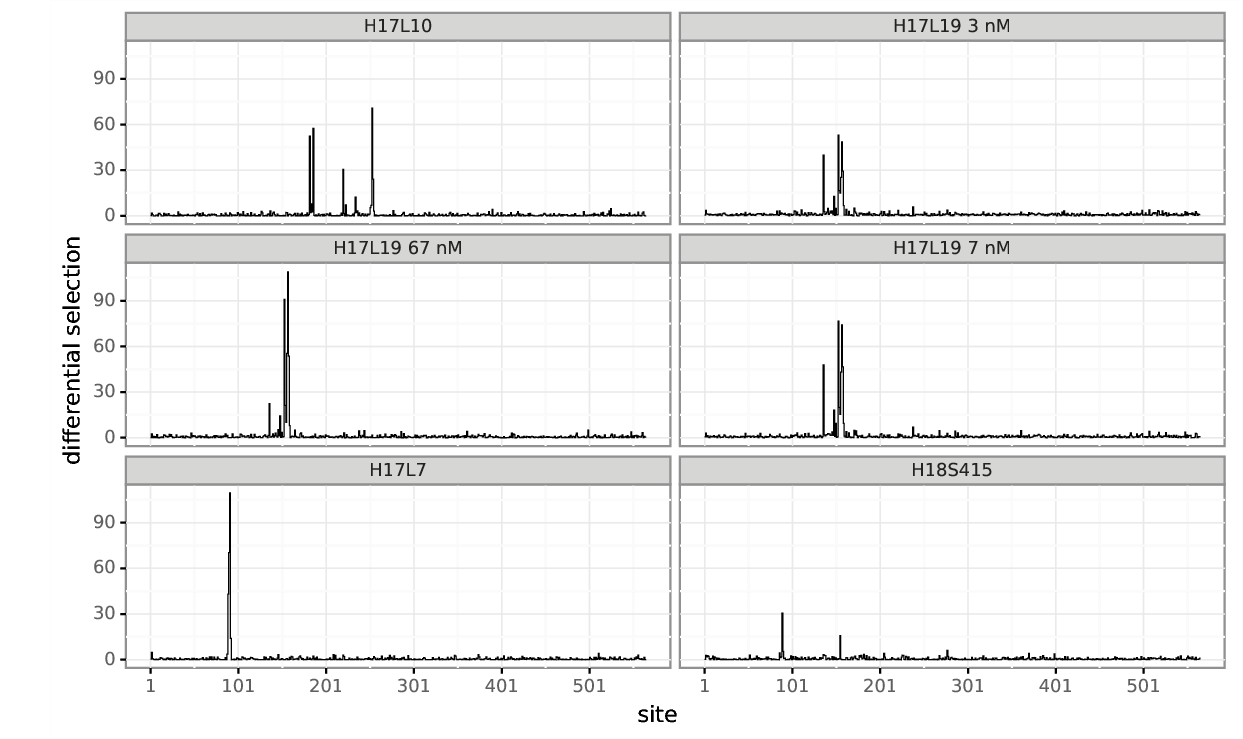

In [22]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf', width=800)

Another plot that can sometimes be useful is the maximum mutation differential selection at each site. 
This measurement is more noisy, but it tells us how strong is the selection for the most favorable mutation at that site, so better detects sites where only one mutation might be substantially favored.
Below we show that, using the median which is typically slightly less noisy for mutation-level measurements:

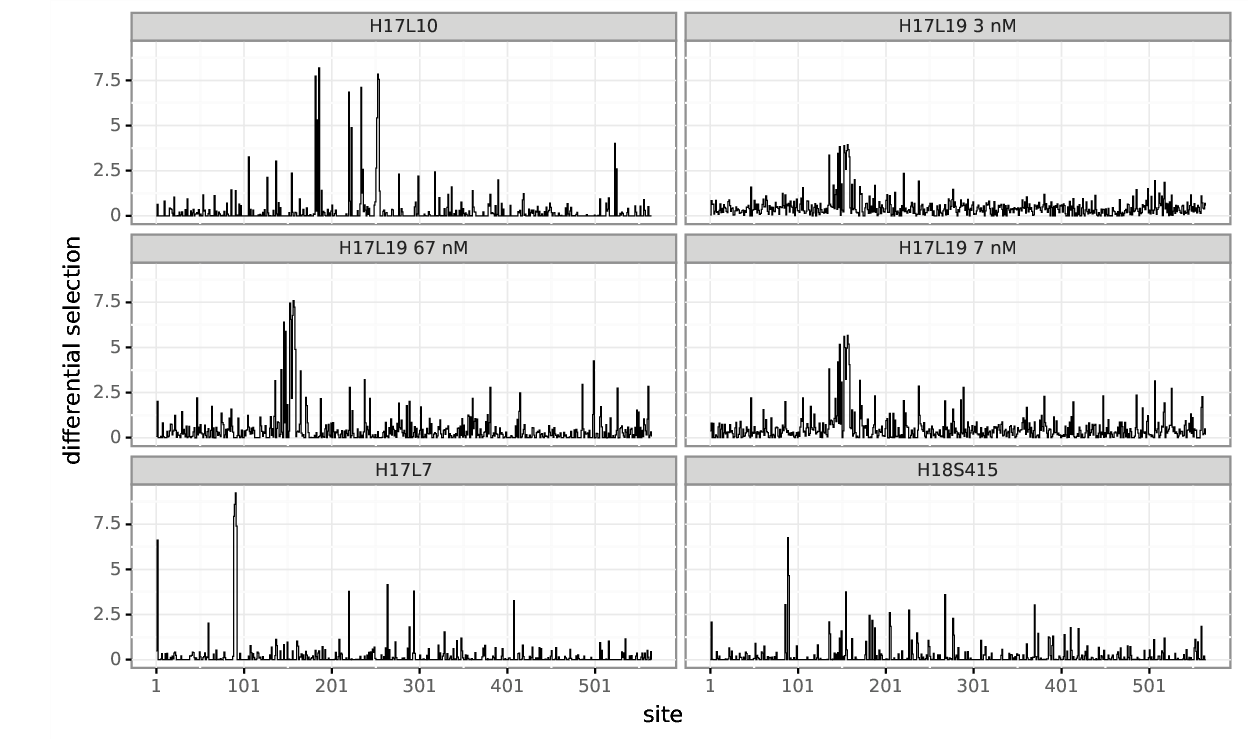

In [23]:
showPDF(diffselprefix + 'medianmaxdiffsel.pdf', width=800)

## Make logo plots visualizing the differential selection
The plots above summarize the site or maximum mutation differential selection using line plots.
But the most comprehensive way to show this selection is in the form of logo plots that can be created with [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).

We make those logo plots using the **median** mutation differential selection values returned by [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).
The reason that we plot the median rather than the mean is that we have noticed that it is often cleaner when there are > 2 replicates.

We also add underlays of the wildtype sequence and of sites of known escape-mutants.
These known escape-mutant sites are from classical experiments from [Caton, Yewdell, and Gerhard](https://www.ncbi.nlm.nih.gov/pubmed/6186384) and are listed in [./data/known_escape.csv](./data/known_escape.csv).
To add the wildtype sequence, we can simply specify any file with the columns `wildtype` and `site` -- any of our mutdiffsel files suffice.
Note that we add these using the `-overlay1` and `--overlay2` options, and then convert them to underlays with `--underlay yes` since underlays look better than overlays here.


Creating logo plot for H17L10 from ./results/diffsel/summary_H17L10-medianmutdiffsel.csv with overlay from ./results/diffsel/summary_H17L10_known_escape.csv


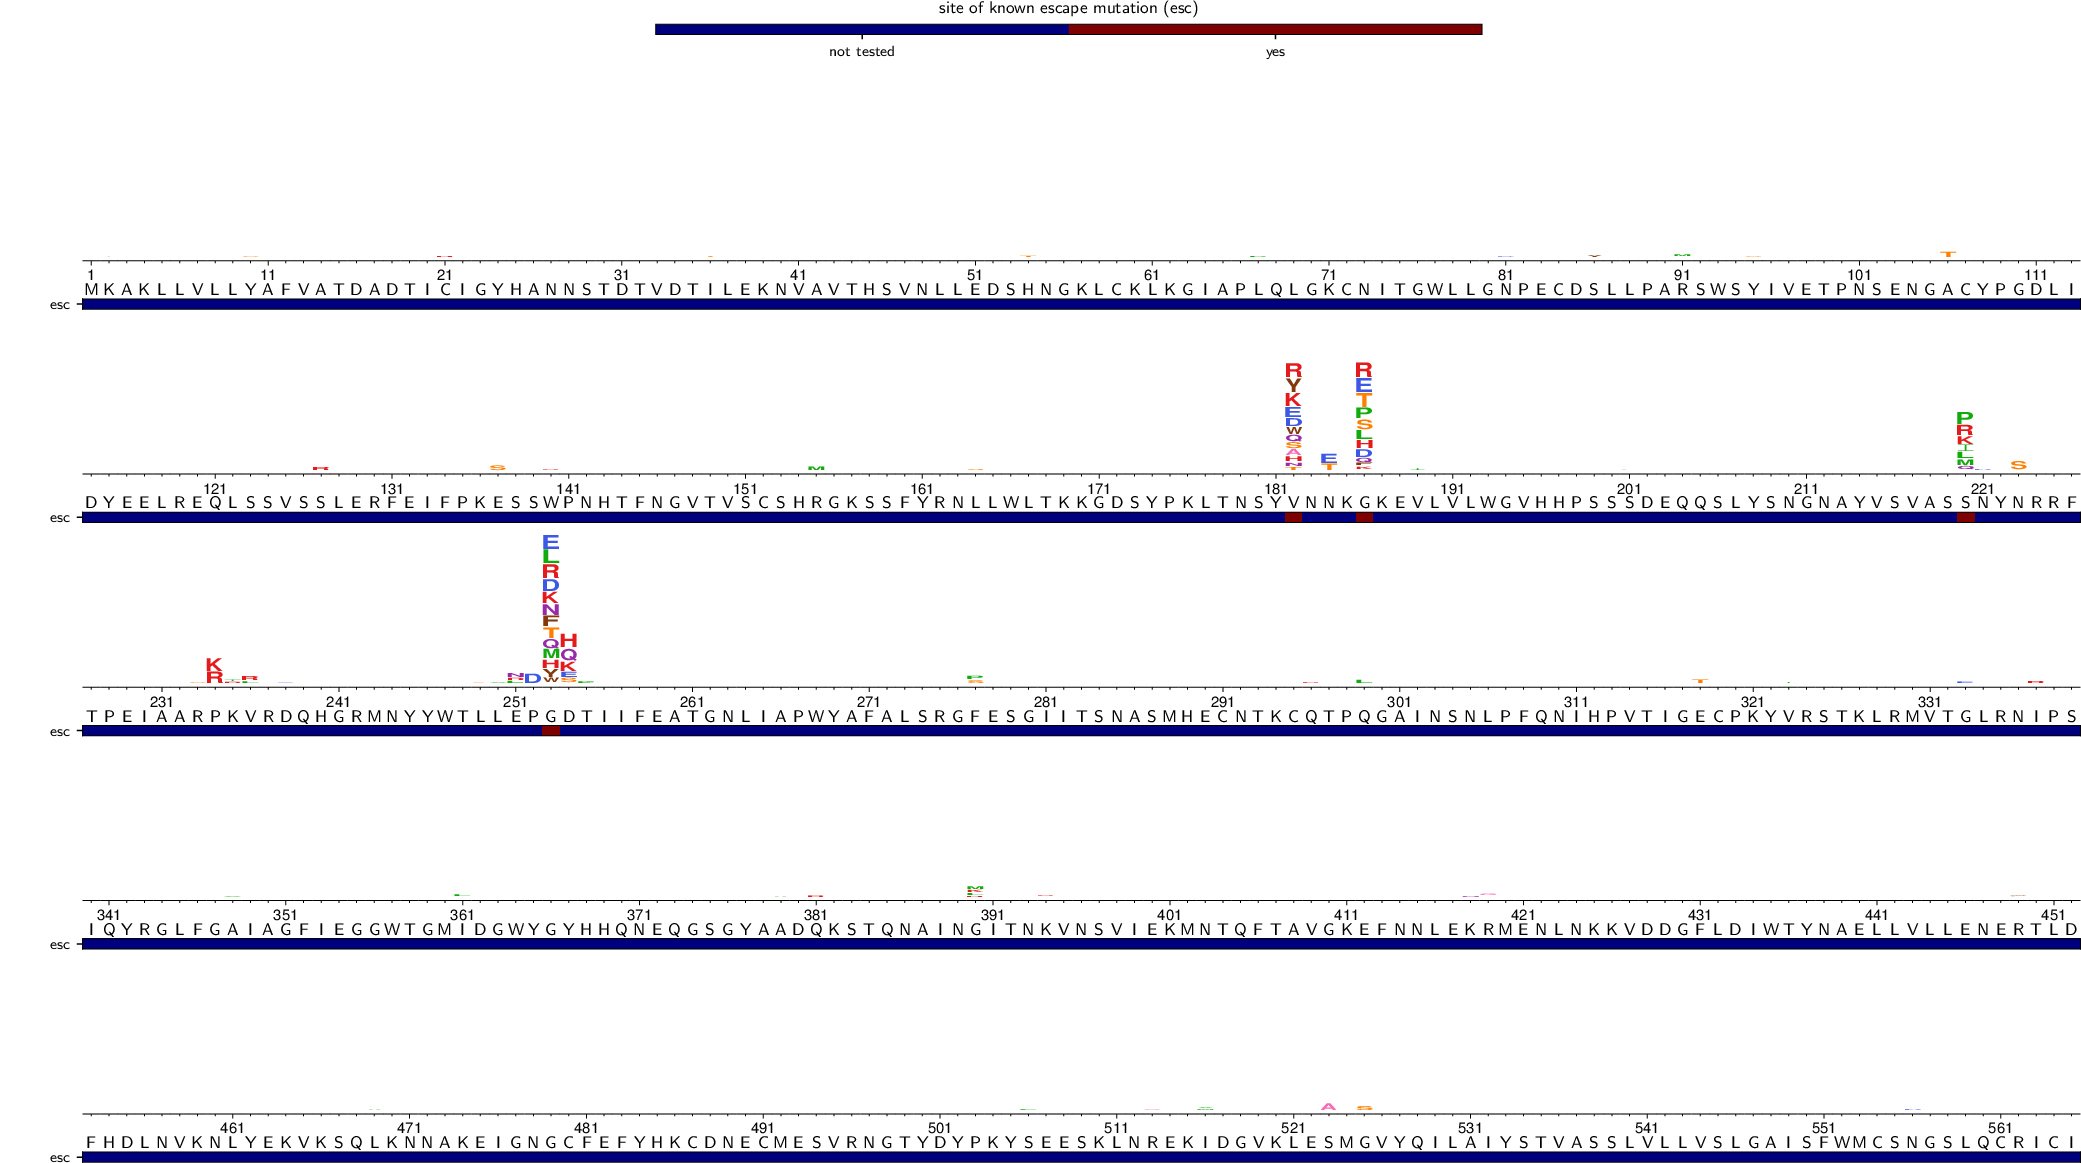


Creating logo plot for H17L19-67-nM from ./results/diffsel/summary_H17L19-67-nM-medianmutdiffsel.csv with overlay from ./results/diffsel/summary_H17L19_known_escape.csv


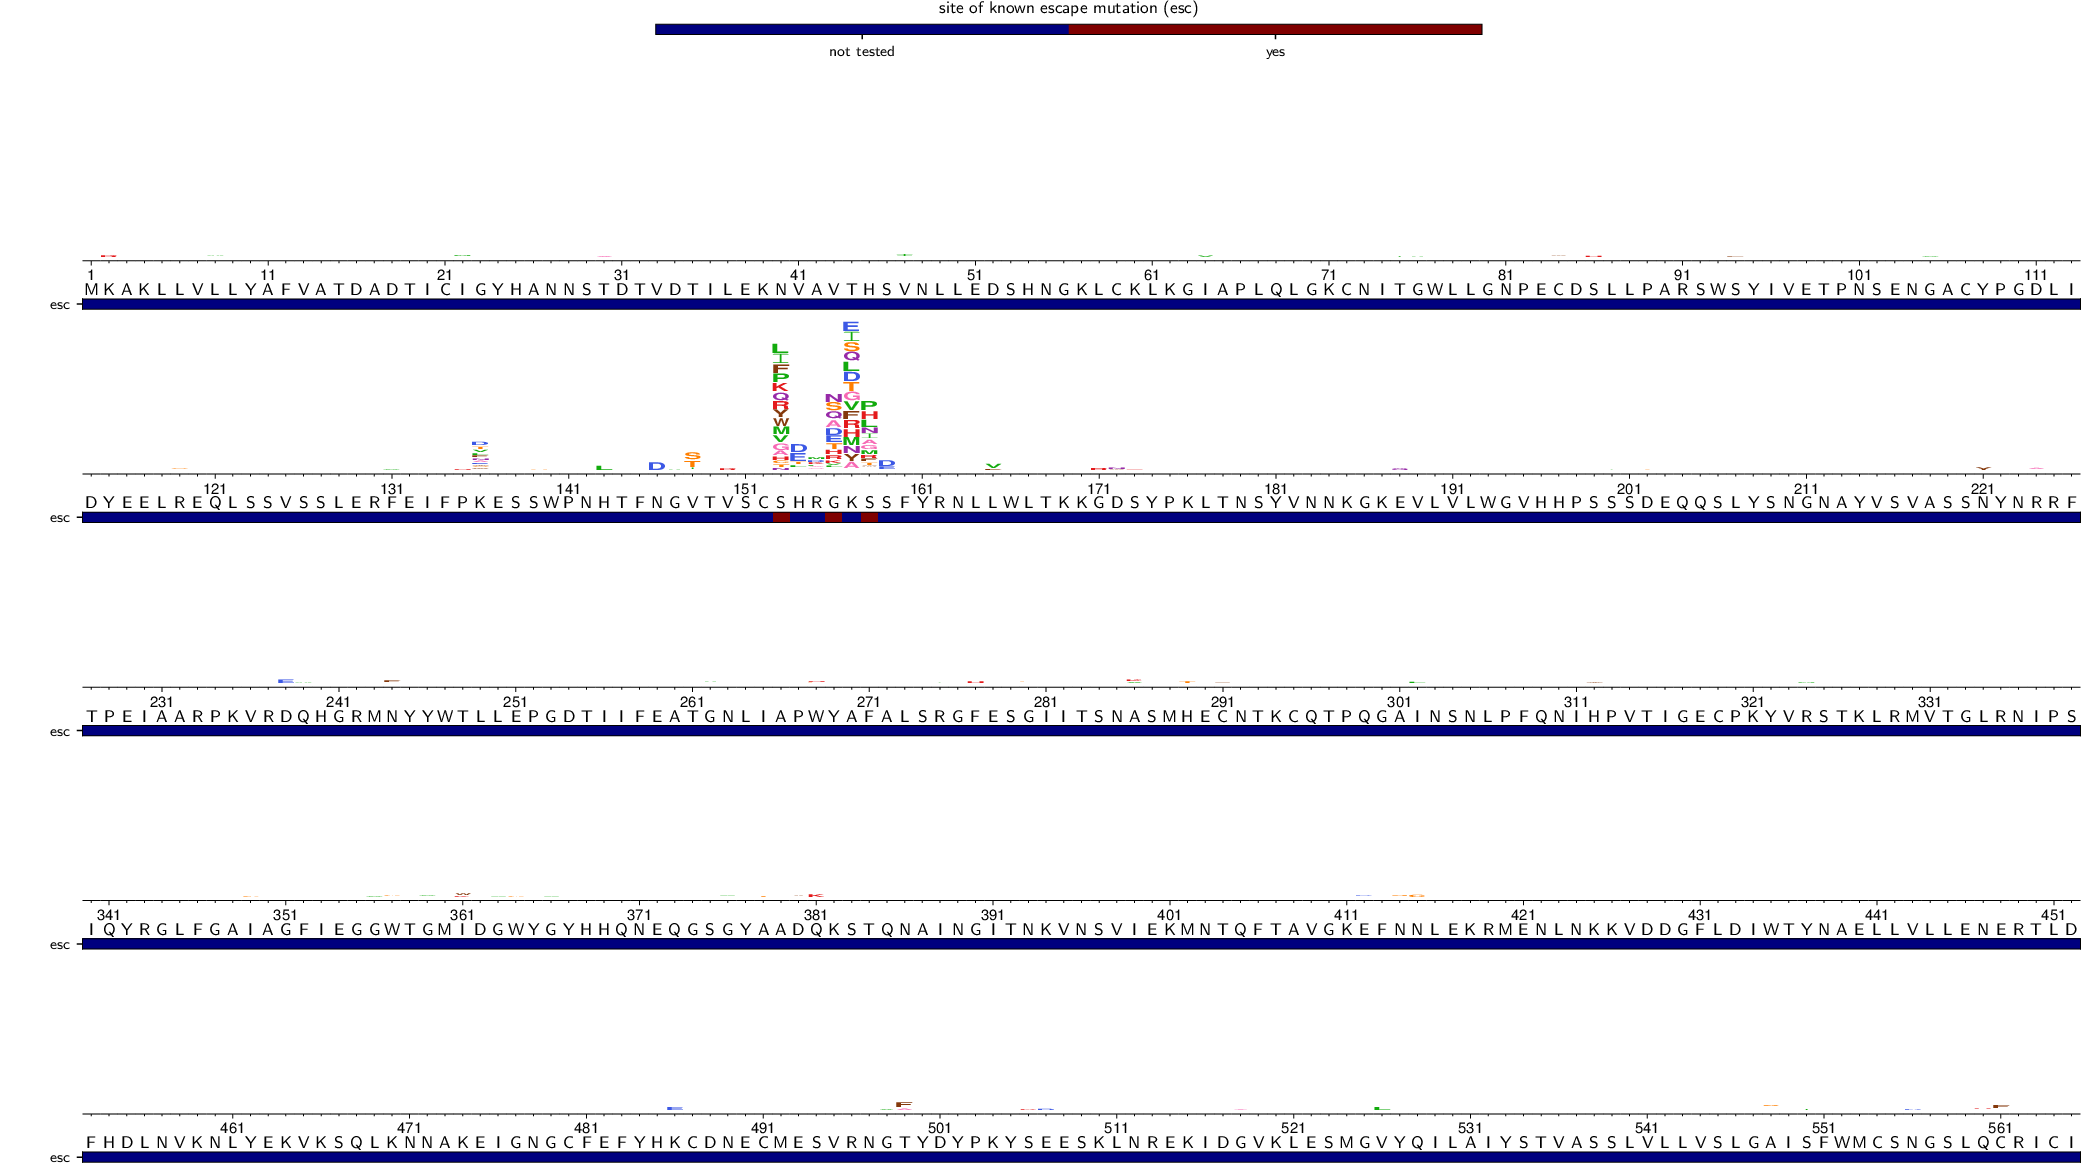


Creating logo plot for H17L7 from ./results/diffsel/summary_H17L7-medianmutdiffsel.csv with overlay from ./results/diffsel/summary_H17L7_known_escape.csv


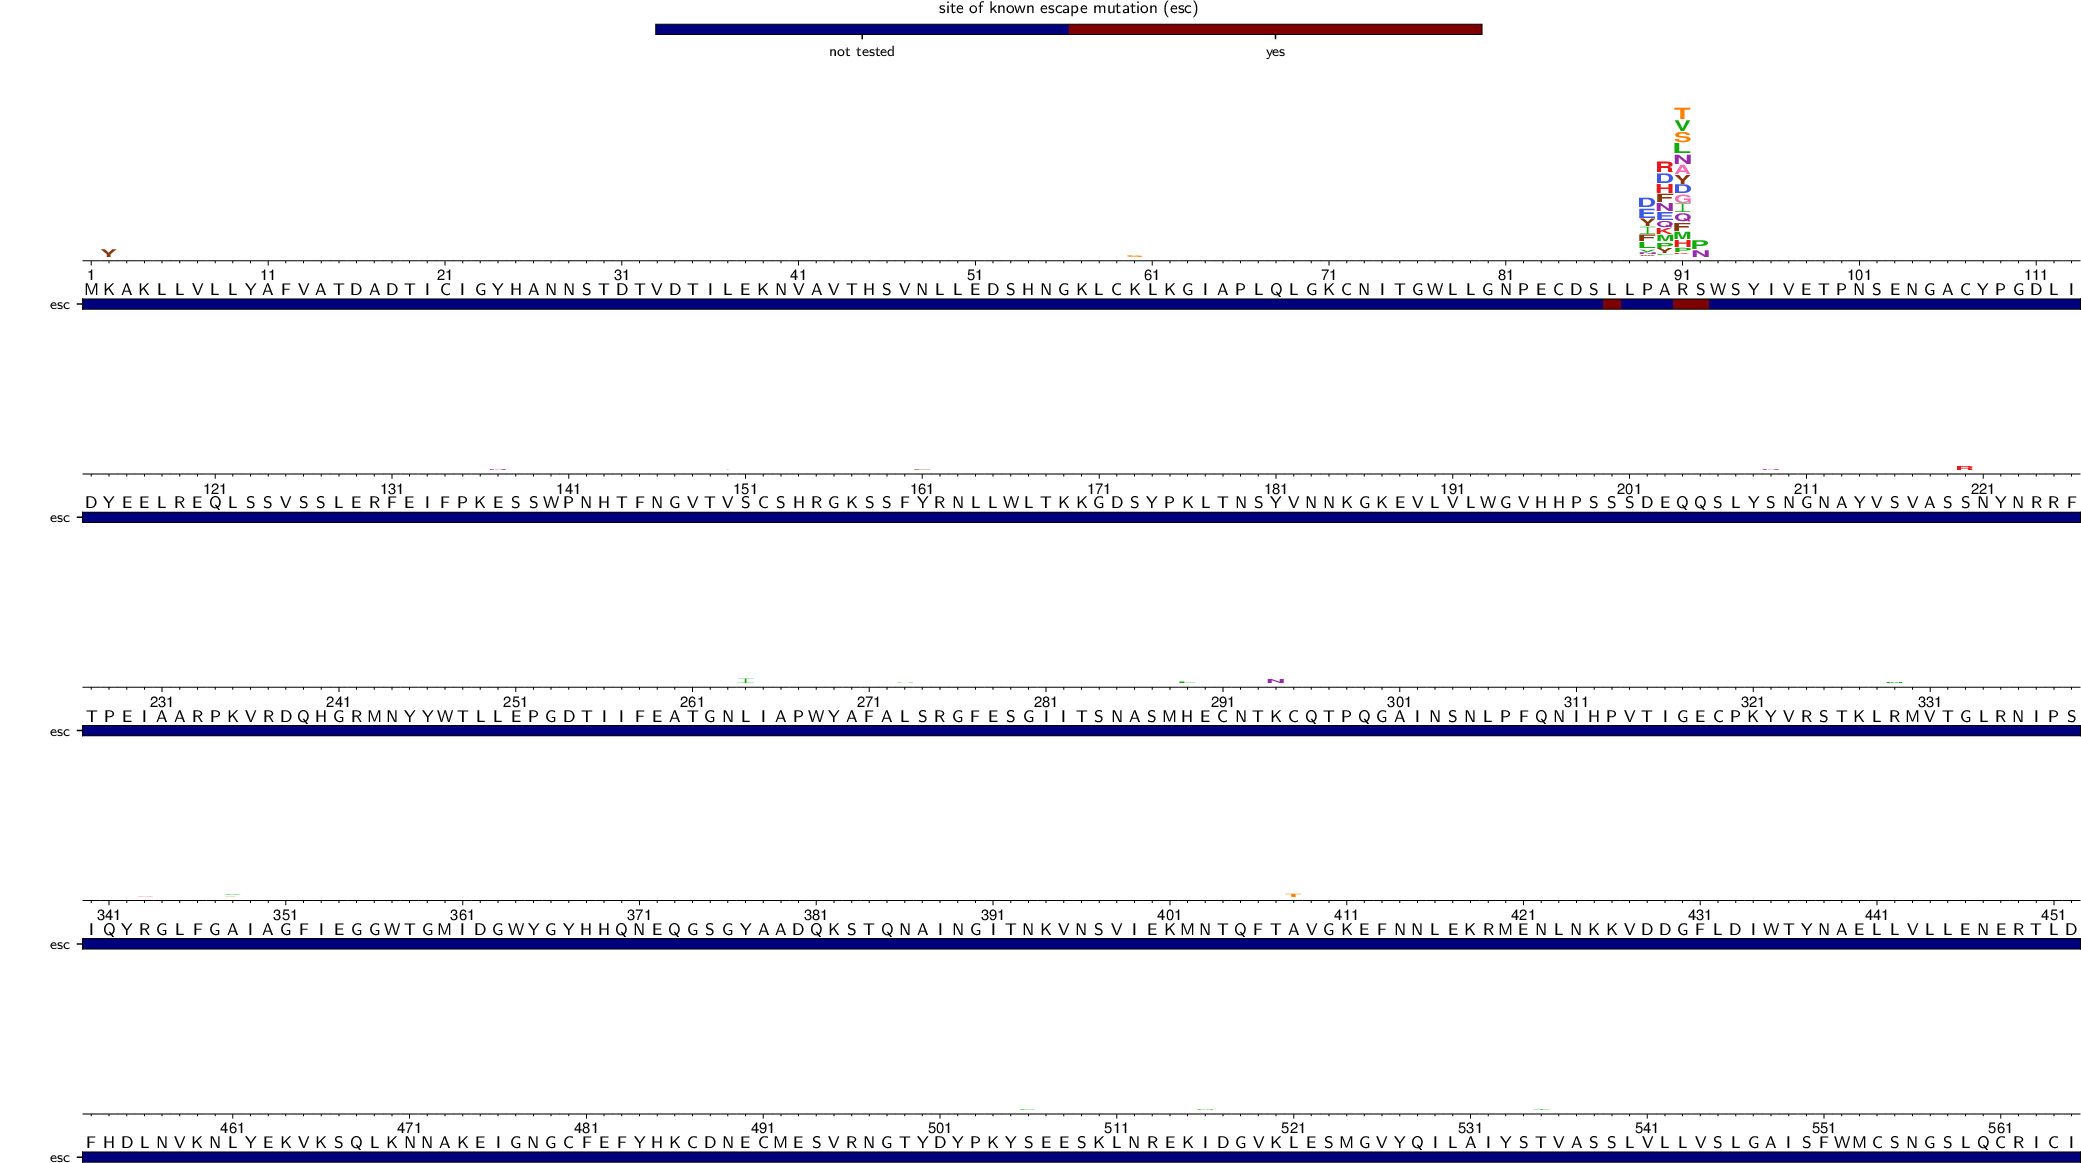


Creating logo plot for H18S415 from ./results/diffsel/summary_H18S415-medianmutdiffsel.csv with overlay from ./results/diffsel/summary_H18S415_known_escape.csv


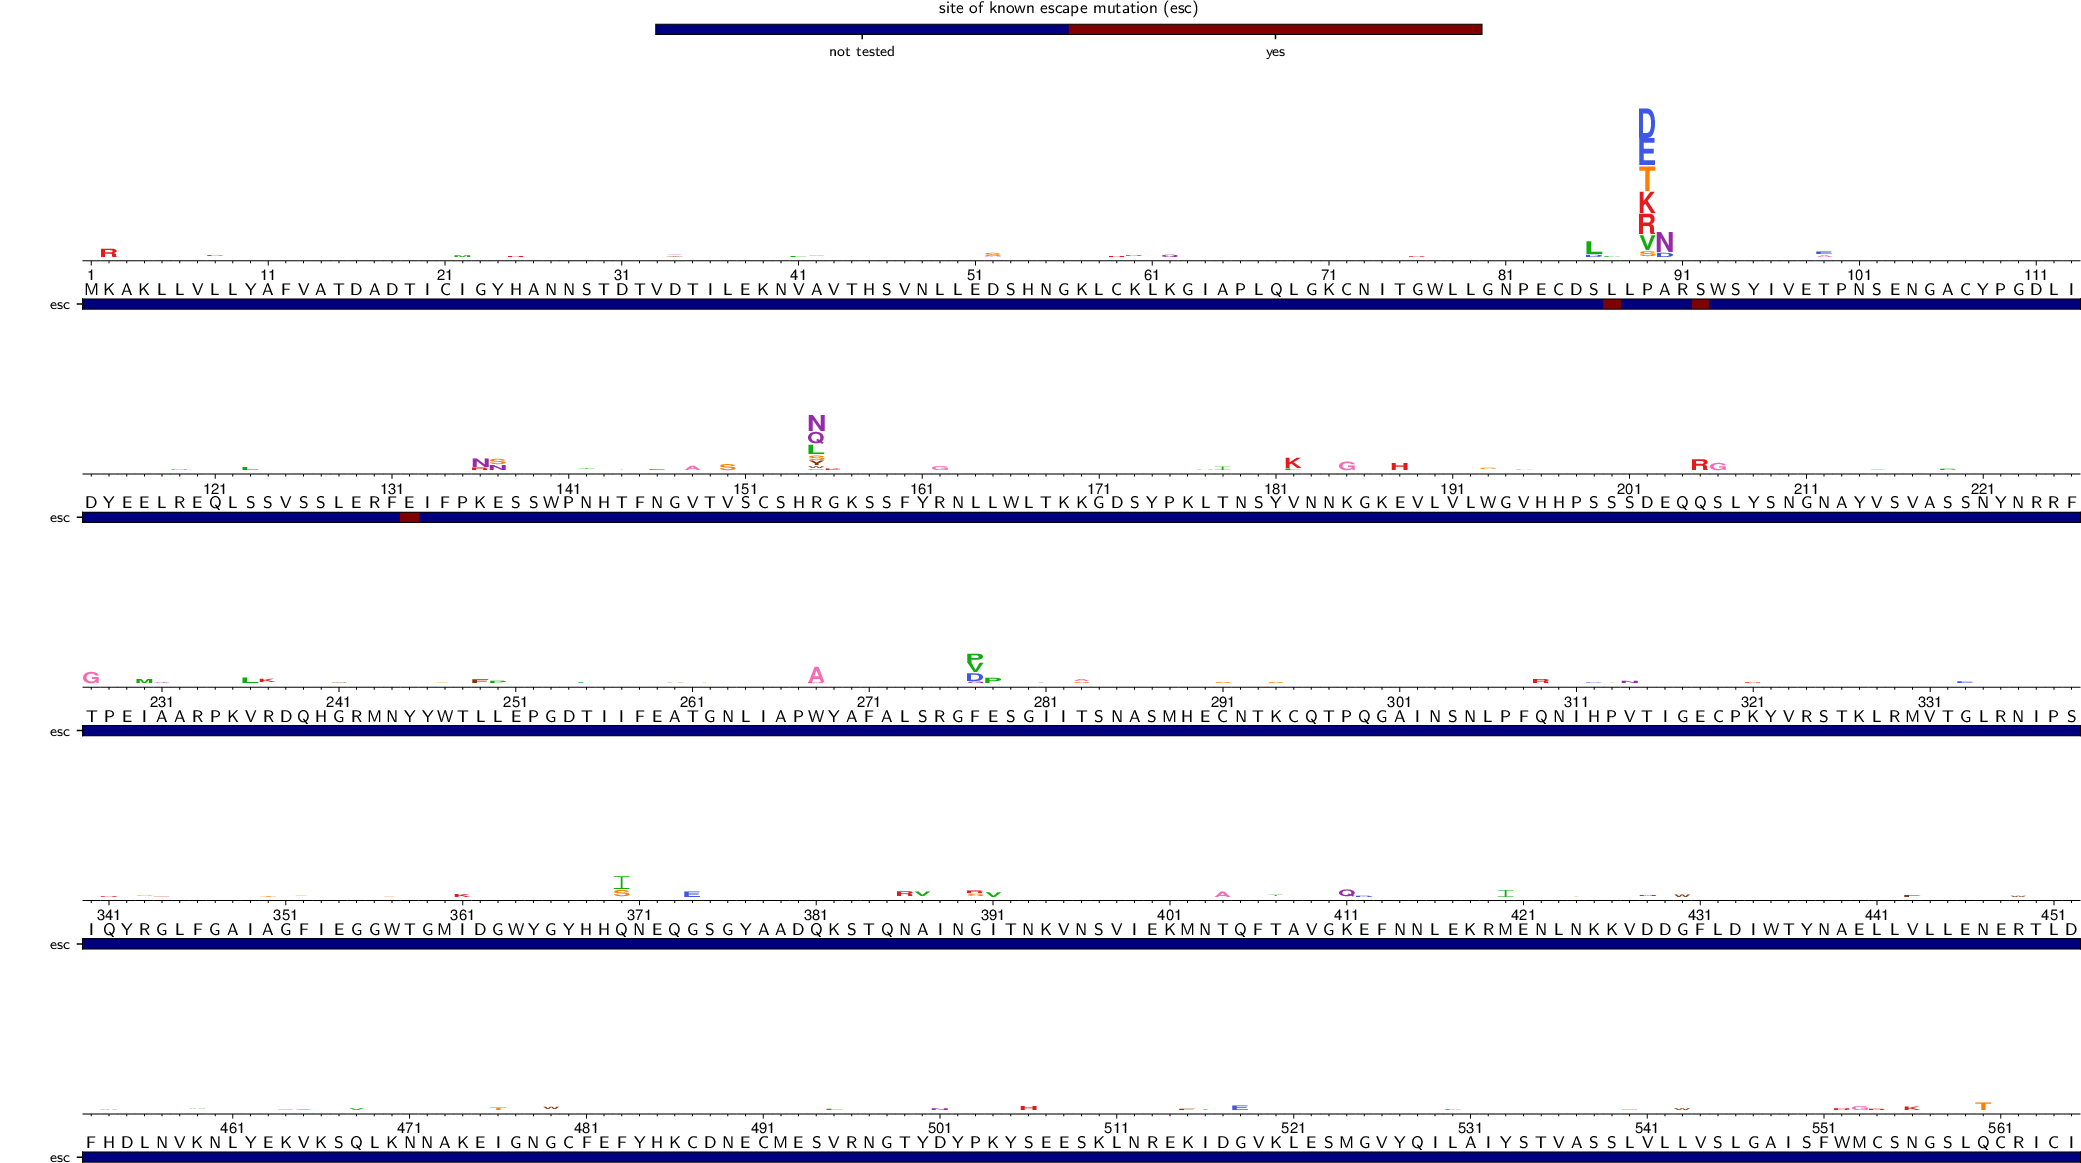

In [24]:
known = pandas.read_csv('./data/known_escape.csv', index_col='site')

for antibody in ['H17L10', 'H17L19-67-nM', 'H17L7', 'H18S415']:
    # mutdiffsel in this file
    mutdiffsel = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # create known sites overlay file to pass to dms2_logoplot
    sites = pandas.read_csv(mutdiffsel)['site'].unique()
    antibodyname = antibody.split('-')[0]
    knownsites = diffselprefix + '{0}_known_escape.csv'.format(antibodyname)
    (known.query('antibody == @antibodyname')
          .assign(esc='yes')
          .reindex(sites) # add entry for sites NOT known to mediate escape
          .reset_index()
          .drop_duplicates('site')
          .fillna('not tested')
          .to_csv(knownsites, index=False)
          )
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(diffseldir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1} with overlay from {2}".format(
            antibody, mutdiffsel, knownsites))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {diffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --nperline 113 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --overlay2 {knownsites} esc "site of known escape mutation" \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)    